In [1]:
cd ..

/home/michael/Desktop/git/ceds-cigar/ES


In [2]:
# Import necessary packages

import numpy as np
import opendssdirect as dss
# from utils.device.Inverter import Inverter
# from utils.controller.AdaptiveInvController import AdaptiveInvController
# from utils.controller.FixedInvController import FixedInvController
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd
import time

from collections import deque

import util.signal_processing as signal_processing

from util.inverter import inverter, inverter_manager

from util.esc import esc, esc_manager

from util.pmu import phasor_measurement_unit, phasor_measurement_unit_manager

from util.voo import voltage_oscillation_observer, voltage_oscillation_observer_manager

from util.vio import voltage_imbalance_observer, voltage_imbalance_observer_manager


# import numpy as np
# from matplotlib.mlab import PCA
# from sklearn.decomposition import PCA

import scipy.linalg as spla

In [3]:
# Simulation Parameters

# Opendss file
fpfn = 'networks/IEEE_13_Node/ieee_13_bus_osc_reg.dss'

# Inverter parameter file

# ESC parameter file


# VOO parameter file


# VIO parameter file



In [4]:
# Set global variables and parameters, and test OpenDSS with network

#######################################################
###Global variable initialization and error checking###
#######################################################

SlackBusVoltage = 1.00
# NoiseMultiplyer= 1

# Select OpenDSS file
dss.run_command('Redirect ' + fpfn)

# Solve power flow with OpenDSS file
dss.Solution.Solve()
if not dss.Solution.Converged():
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(50000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')

print('')

# Set slack bus (sourcebus) voltage reference in p.u. 
dss.Vsources.PU(SlackBusVoltage)

# Print number of buses, and bus names
print('Number of Buses: ' + str(len(dss.Circuit.AllBusNames())))
print('Buses: ' + str(dss.Circuit.AllBusNames()))
print('')

# Print number of line, and line names
print('Number of Lines: ' + str(len(dss.Lines.AllNames())))
print('Lines: ' + str(dss.Lines.AllNames()))
print('')

# Print number of loads, and load names
print('Number of Loads: ' + str(len(dss.Loads.AllNames())))
print('Loads: ' + str(dss.Loads.AllNames()))
print('')

##        
for k1 in range(len(dss.Circuit.AllBusNames())):
    dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
    print(dss.Circuit.AllBusNames()[k1])
    print('BASE - LN')
    print(dss.Bus.kVBase())
    print('VMAGANGLE - LN POLAR')
    print(dss.Bus.VMagAngle())
    print('puVMAGANGLE - LN POLAR')
    print(dss.Bus.puVmagAngle())
    print('')

for k1 in range(len(dss.RegControls.AllNames())):
    print(dss.RegControls.AllNames()[k1])
    dss.RegControls.Name(dss.RegControls.AllNames()[k1])
    print(dss.RegControls.TapNumber())
    print('')


Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.

Number of Buses: 16
Buses: ['sourcebus', '650', 'rg60', '633', '634', '632', '670', '671', '680', '645', '646', '692', '675', '684', '611', '652']

Number of Lines: 12
Lines: ['line_650_632', 'line_632_670', 'line_670_671', 'line_671_680', 'line_632_633', 'line_632_645', 'line_645_646', 'line_692_675', 'line_671_684', 'line_684_611', 'line_684_652', 'line_671_692']

Number of Loads: 16
Loads: ['load_671', 'load_634a', 'load_634b', 'load_634c', 'load_645', 'load_646', 'load_692', 'load_675a', 'load_675b', 'load_675c', 'load_611', 'load_652', 'load_670a', 'load_670b', 'load_670c', 'load_670ab']

sourcebus
BASE - LN
66.39528095680697
VMAGANGLE - LN POLAR
[66393.49491450745, 29.992704064003966, 66394.83846121102, -90.00948094145255, 66391.9739292852, 149.99060739969676]
puVMAGANGLE - LN POLAR
[0.9999730998608067, 29.992704064003966, 0.9999933354360496, -90.00948094145255, 0.9999501918287851, 149.990607399696

In [5]:
# Run simulation

tappos = np.array([9, 6, 9])
for k1 in range(len(dss.RegControls.AllNames())):
    print(dss.RegControls.AllNames()[k1])
    dss.RegControls.Name(dss.RegControls.AllNames()[k1])
    print(dss.RegControls.TapNumber())
    # dss.RegControls.TapNumber(dss.RegControls.TapNumber())
    print('')    

# time array
Ts = 0.01
time = np.around(np.arange(0,60+Ts,Ts),2)

# All buses and bus voltages
AllBuses = dss.Circuit.AllBusNames()
AllBusVoltage = np.zeros((len(time),len(AllBuses)))
AllBuskVBase = np.zeros(len(time))

for k1 in range(len(AllBuses)):
    dss.Circuit.SetActiveBus(AllBuses[k1])
    print(dss.Bus.Name())
    print(dss.Bus.kVBase())
    AllBuskVBase[k1] = dss.Bus.kVBase()

print(AllBuses)
print(AllBuskVBase)

# All loads and load voltages
AllLoads = dss.Loads.AllNames()
LoadBusVoltage = np.zeros((len(time),len(AllLoads)))


##################################################
# Set up inverters
##################################################    
    
# inverter_params = pd.read_csv('imbalance/config_01_ieee_13/inverter_params_13.csv')
# inverter_params['Toff'] = 1/100*np.floor(10*np.random.rand(inverter_params.shape[0]))

# # inverter_params['Toff'].loc[2]
    
# inverterlist = []
# for k1 in range(inverter_params.shape[0]):
#     tempinverter = inverter()
#     tempinverter.set_timesteps(Ts,time,len(time))
#     tempinverter.set_opertime(inverter_params['Top'].loc[k1],inverter_params['Toff'].loc[k1])
#     tempinverter.set_busname(str(inverter_params['Bus'].loc[k1]))
#     tempinverter.set_phase(inverter_params['Phase'].loc[k1])
#     tempinverter.set_connection(inverter_params['Conn'].loc[k1])
        
#     count = 0
#     for k2 in range(0,k1+1):
#         if inverter_params['Bus'].loc[k2] == inverter_params['Bus'].loc[k1] and inverter_params['Phase'].loc[k2] == inverter_params['Phase'].loc[k1]:
#             count = count + 1
    
#     temploadname = 'inv_' + str(inverter_params['Bus'].loc[k1]) + '_' + str(inverter_params['Phase'].loc[k1]) + '_' + str(count)
#     print(temploadname)
    
#     dss.Text.Command('New Load.' + temploadname + ' Bus1=' + str(inverter_params['Bus'].loc[k1]) + '.' + str(inverter_params['Phase'].loc[k1]) + ' Phases=1 Conn=Wye Model=1 kV=2.400 kW=0.0 kVAR=0.0')
    
#     tempinverter.set_loadname(temploadname)
#     tempinverter.set_VBP(np.array([0.95, 0.98, 1.02, 1.05]))
#     tempinverter.set_VBP(np.array([0.95, 0.99, 1.01, 1.05]))
#     tempinverter.set_lowpass_frequency(2*np.pi*inverter_params['flp'].loc[k1])
#     tempinverter.set_VAr_capacity(inverter_params['kVAr'].loc[k1])
#     tempinverter.set_VAr_capacity(300)
    
#     inverterlist.append(tempinverter)


##################################################
##### Set up ESCs
##################################################

# esc_params = pd.read_csv('imbalance/config_01_ieee_13/esc_params_13.csv')
# esc_params['Toff'] = 1/100*np.floor(10*np.random.rand(esc_params.shape[0]))

# # inverter_params['Toff'].loc[2]

# escidxlist = [0, 1, 2]
    
# esclist = []
# for k2 in range(0,3):
#     k1 = escidxlist[k2]
# # for k1 in range(0,4):#,esc_params.shape[0]):
#     tempesc = esc()
#     tempesc.set_timesteps(Ts,time,len(time))
#     tempesc.set_opertime(esc_params['Top'].loc[k1],esc_params['Toff'].loc[k1])    
#     tempesc.set_busname(str(esc_params['Bus'].loc[k1]))
#     tempesc.set_phase(esc_params['Phase'].loc[k1])
#     tempesc.set_connection(esc_params['Conn'].loc[k1])  
        
#     count = 0
#     for k2 in range(0,k1+1):
#         if esc_params['Bus'].loc[k2] == esc_params['Bus'].loc[k1] and esc_params['Phase'].loc[k2] == esc_params['Phase'].loc[k1]:
#             count = count + 1
    
#     temploadname = 'esc_' + str(esc_params['Bus'].loc[k1]) + '_' + str(esc_params['Phase'].loc[k1]) + '_' + str(count)
#     print(temploadname)
    
#     if len(esc_params['Phase'].loc[k1].split('.')) == 1:
#         dss.Text.Command('New Load.' + temploadname + ' Bus1=' + str(esc_params['Bus'].loc[k1]) + '.' + str(esc_params['Phase'].loc[k1]) + ' Phases=1 Conn=Wye Model=1 kV=2.400 kW=0.0 kVAR=0.0')
#     elif len(esc_params['Phase'].loc[k1].split('.')) == 2:
#         dss.Text.Command('New Load.' + temploadname + ' Bus1=' + str(esc_params['Bus'].loc[k1]) + '.' + str(esc_params['Phase'].loc[k1]) + ' Phases=2 Conn=Wye Model=1 kV=4.16 kW=0.0 kVAR=0.0')
#     elif len(esc_params['Phase'].loc[k1].split('.')) == 3:
#         dss.Text.Command('New Load.' + temploadname + ' Bus1=' + str(esc_params['Bus'].loc[k1]) + '.' + str(esc_params['Phase'].loc[k1]) + ' Phases=3 Conn=Wye Model=1 kV=4.16 kW=0.0 kVAR=0.0')
    
#     tempesc.set_loadname(temploadname)

#     tempesc.set_esc_params(esc_params['fes'].loc[k1],esc_params['aes'].loc[k1],esc_params['kint'].loc[k1])
#     tempesc.set_esc_limits(2*esc_params['pmin'].loc[k1],2*esc_params['pmax'].loc[k1],2*esc_params['qmin'].loc[k1],2*esc_params['qmax'].loc[k1],4*esc_params['smax'].loc[k1])
    
#     esclist.append(tempesc)

##################################################
#####
##################################################

esclist = []

import json

with open('imbalance/config_01.json') as f:
    jsondata = json.load(f)

# Output: {'name': 'Bob', 'languages': ['English', 'Fench']}
# print(data['inverters'])

# for k1 in range(len(data['inverters'])):

#     print(data['inverters'][k1])

print('\n~~~~~ Inverters ~~~~')

inverter_manager = inverter_manager(time, Ts, AllBuses, AllBuskVBase, jsondata)
inverterlist = inverter_manager.parse_json()
for inverter in inverterlist:
    dss.run_command(inverter.dss_command_str)
    print(inverter.busname)

##################################################
#####
##################################################

print('\n~~~~~ ESCs ~~~~')

esc_manager = esc_manager(time, Ts, AllBuses, AllBuskVBase, jsondata)
esclist = esc_manager.parse_json()
for esc in esclist:
    dss.run_command(esc.dss_command_str)

##################################################
#####
##################################################

print('\n~~~~~ PMUs ~~~~')

pmulist = []

##################################################
#####
##################################################

print('\n~~~~~ LPMs ~~~~')

lpmlist = []

##################################################
#####
##################################################

print('\n~~~~~ LVMs ~~~~')

lvmlist = []

##################################################
#####
##################################################

print('\n~~~~~ VIOs ~~~~')

vio_manager = voltage_imbalance_observer_manager(time, Ts, jsondata)
violist = vio_manager.parse_json()
for vio in violist:
    # dss.run_command(esc.dss_command_str)
    pass

    
##################################################
#####
##################################################

print('\n~~~~~ VOOs ~~~~')

# voolist = []

# voolist.append(voltage_oscillation_observer())
# voolist[0].set_timesteps(Ts,time,len(time))
# voolist[0].set_opertime(0.1, 0.0)
# voolist[0].set_busname('632')
# voolist[0].set_conn('wye')
# voolist[0].set_phase(1)

# voolist.append(voltage_oscillation_observer())
# voolist[1].set_timesteps(Ts,time,len(time))
# voolist[1].set_opertime(0.1, 0.0)
# voolist[1].set_busname('632')
# voolist[1].set_conn('wye')
# voolist[1].set_phase(2)

# voolist.append(voltage_oscillation_observer())
# voolist[2].set_timesteps(Ts,time,len(time))
# voolist[2].set_opertime(0.1, 0.0)
# voolist[2].set_busname('632')
# voolist[2].set_conn('wye')
# voolist[2].set_phase(3)

# print('')

voo_manager = voltage_oscillation_observer_manager(time, Ts, jsondata)
voolist = voo_manager.parse_json()
for voo in voolist:
    # dss.run_command(esc.dss_command_str)
    pass

##################################################
#####
##################################################

# All buses and bus voltages
AllBuses = dss.Circuit.AllBusNames()
AllBusVoltage = np.zeros((len(time),3,len(AllBuses)))
print('BUSES:', AllBuses)

# All loads and load voltages
AllLoads = dss.Loads.AllNames()
LoadBusVoltage = np.zeros((3,len(time),len(AllLoads)))
print('LOADS:', AllLoads)

# LoadBusPinj = np.zeros((3,len(time),len(AllLoads))) 
# LoadBusQinj = np.zeros((3,len(time),len(AllLoads)))

# kWloadTS = np.zeros((3,len(time),len(AllLoads)))
# kVArloadTS = np.zeros((3,len(time),len(AllLoads)))

# kWtotalTS = np.zeros((3,len(time),len(AllLoads)))
# kVArtotalTS = np.zeros((3,len(time),len(AllLoads)))

# Real power load, injection, total for load buses
PloadTS = np.zeros((len(time),len(AllLoads)))
PinvTS = np.zeros((len(time),len(AllLoads)))
PescTS = np.zeros((len(time),len(AllLoads)))
PtotalTS = np.zeros((len(time),len(AllLoads)))

# Reactive power load, injection, total for load buses
QloadTS = np.zeros((len(time),len(AllLoads)))
QinvTS = np.zeros((len(time),len(AllLoads)))
QescTS = np.zeros((len(time),len(AllLoads)))
QtotalTS = np.zeros((len(time),len(AllLoads)))

# Nominal real and reactive power loads in kW and kVAr, from OpenDSS file
PloadNominal = np.zeros(len(AllLoads))
QloadNominal = np.zeros(len(AllLoads))
# Array of frequencies for load modulation
lf = np.zeros(len(AllLoads))
for k1 in range(len(AllLoads)):
    dss.Loads.Name(AllLoads[k1])
    PloadNominal[k1] = dss.Loads.kW()
    QloadNominal[k1] = dss.Loads.kvar()
    lf[k1] = 1 + 0.2*(np.random.rand()-0.5)
    
print(PloadNominal)
print(QloadNominal)
print(lf)
print('')

Vimb = np.zeros((len(time),4))

# iterate through timesteps
for kt in range(0,len(time)):
       
    # print when each minute has elapsed
    if time[kt] % 10 == 0:
        hh = int((time[kt])/3600)
        mm = int(((time[kt]) - 3600*int((time[kt])/3600))/60)
        if mm <= 9:
            print(str(hh) + '.0' + str(mm))
        else:
            print(str(hh) + '.' + str(mm))
    
    # At first time step, initialize loads, with no control
    if kt == 0:
        
        for k1 in range(len(AllLoads)):
                
            dss.Loads.Name(AllLoads[k1])
                            
            PloadTS[kt,k1] = PloadNominal[k1]
            dss.Loads.kW(PloadTS[kt,k1])

            QloadTS[kt,k1] = QloadNominal[k1]
            dss.Loads.kvar(QloadTS[kt,k1])                
            
            if dss.Loads.IsDelta() == False:
                pass
            
            if dss.Loads.IsDelta() == True:                    
                pass

        for k1 in range(len(inverterlist)):            
            
            dss.Loads.Name(inverterlist[k1].loadname)

            PinvTS[kt,k1] = 0
            dss.Loads.kW(0)

            QinvTS[kt,k1] = 0
            dss.Loads.kvar(0)

        for k1 in range(len(esclist)):
            
            dss.Loads.Name(esclist[k1].loadname)

            PescTS[kt,k1] = 0
            dss.Loads.kW(0)

            QescTS[kt,k1] = 0
            dss.Loads.kvar(0)
                
                
    # Compute total loading
    else:
        
        for k1 in range(len(AllLoads)):
#             if 'load' in AllLoads[k1]:
                
            dss.Loads.Name(AllLoads[k1])

            PloadTS[kt,k1] = (1.0 + 0*0.15*np.sin(2*np.pi*lf[k1]*1/120*time[kt]))*PloadNominal[k1] + 0*50*np.random.rand()
            dss.Loads.kW(PloadTS[kt,k1])

            QloadTS[kt,k1] = (1.0 + 0*0.10*np.sin(2*np.pi*lf[k1]*1/120*time[kt]))*QloadNominal[k1] + 0*20*np.random.rand()
            dss.Loads.kvar(QloadTS[kt,k1])
                
        for k1 in range(len(inverterlist)):            
            
            dss.Loads.Name(inverterlist[k1].loadname)

            PinvTS[kt,k1] = inverterlist[k1].pin[inverterlist[k1].kop-1]
            dss.Loads.kW(0*inverterlist[k1].pin[inverterlist[k1].kop-1])

            QinvTS[kt,k1] = inverterlist[k1].qin[inverterlist[k1].kop-1]
            dss.Loads.kvar(1*inverterlist[k1].qin[inverterlist[k1].kop-1])

            # PinvTS[kt,k1] = inverterlist[k1].pin[-1]
            # dss.Loads.kW(PinvTS[kt,k1])

            # QinvTS[kt,k1] = inverterlist[k1].qin[-1]
            # dss.Loads.kvar(QinvTS[kt,k1])
            
        for k1 in range(len(esclist)):
            
            dss.Loads.Name(esclist[k1].loadname)

            PescTS[kt,k1] = esclist[k1].p[esclist[k1].kop-1]
            dss.Loads.kW(0*esclist[k1].p[esclist[k1].kop-1])

            QescTS[kt,k1] = esclist[k1].q[esclist[k1].kop-1]
            dss.Loads.kvar(0*esclist[k1].q[esclist[k1].kop-1])

    # tappos = np.array([9, 6, 9])
    # for k1 in range(len(dss.RegControls.AllNames())):
    #     # print(dss.RegControls.AllNames()[k1])
    #     dss.RegControls.Name(dss.RegControls.AllNames()[k1])
    #     # print(dss.RegControls.TapNumber())
    #     dss.RegControls.TapNumber(tappos[k1])
    #     # print('')


    # solve power flow with OpenDSS file and newly assigned loads
#     dss.Monitors.ResetAll()
    dss.Solution.Solve()
    if not dss.Solution.Converged():
        print('Solution Not Converged at Step: ', kt)
#         pass
        
    dss.Monitors.SampleAll()
    #get the voltage info

    # tappos = np.array([9, 6, 9])
    # for k1 in range(len(dss.RegControls.AllNames())):
    #     # print(dss.RegControls.AllNames()[k1])
    #     dss.RegControls.Name(dss.RegControls.AllNames()[k1])
    #     # print(dss.RegControls.TapNumber())
    #     dss.RegControls.TapNumber(tappos[k1])
    #     # print('')


    for k1 in range(len(dss.Circuit.AllBusNames())):
        
        dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
        
    #     print(dss.Circuit.AllBusNames()[k1])
    #     print(dss.Bus.Nodes())

    #     print('puVOTLAGES - LN CARTESIAN')
    #     print(dss.Bus.PuVoltage())

        ph = np.asarray(dss.Bus.Nodes(),dtype='int')-1
        
        Vtemp = np.asarray(dss.Bus.puVmagAngle())[::2]

        AllBusVoltage[kt,ph,k1] = Vtemp


    #########################
    #########################
    #########################

    for pmu in pmulist:

        # Initialize
        if kt == 0:

            pmu.kop = 0
            pmu.timeop[pmu.kop] = time[kt]

            dss.Circuit.SetActiveBus(pmu.busname)
            ph = np.asarray(dss.Bus.Nodes(),dtype='int')-1

            pmu.Vmag[ph,pmu.kop] = np.asarray(dss.Bus.puVmagAngle())[::2]
            pmu.Vang[ph,pmu.kop] = np.asarray(dss.Bus.puVmagAngle())[1::2]

            pmu.Vcomp[ph,pmu.kop] = np.asarray(dss.Bus.PuVoltage())[::2] + 1j*np.asarray(dss.Bus.PuVoltage())[1::2]
            pmu.Vreal[ph,pmu.kop] = np.asarray(dss.Bus.PuVoltage())[::2]
            pmu.Vimag[ph,pmu.kop] = np.asarray(dss.Bus.PuVoltage())[1::2]

        if time[kt] >= pmu.Tlast + pmu.Top:

            # Increase operation step index, and operation time
            pmu.kop += 1
            pmu.timeop[pmu.kop] = time[kt]

            dss.Circuit.SetActiveBus(pmu.busname)
            ph = np.asarray(dss.Bus.Nodes(),dtype='int')-1

            pmu.Vmag[ph,pmu.kop] = np.asarray(dss.Bus.puVmagAngle())[::2]
            pmu.Vang[ph,pmu.kop] = np.asarray(dss.Bus.puVmagAngle())[1::2]

            pmu.Vcomp[ph,pmu.kop] = np.asarray(dss.Bus.PuVoltage())[::2] + 1j*np.asarray(dss.Bus.PuVoltage())[1::2]
            pmu.Vreal[ph,pmu.kop] = np.asarray(dss.Bus.PuVoltage())[::2]
            pmu.Vimag[ph,pmu.kop] = np.asarray(dss.Bus.PuVoltage())[1::2]

            # Set time of last elapsed operation step
            pmu.Tlast = time[kt]


    #########################
    #########################
    #########################
    
    # if kt == 0:
        
    #     dss.Lines.Name(lpm.linename)
    #     Sk = dss.CktElement.Powers()
    #     Pmeas = Sk[0]
    #     Qmeas = Sk[1]
        
    #     lpm.calc_objective(kt, Pmeas, Qmeas)
        
    #     lpm.kop = 0
    #     lpm.timeop[lpm.kop] = time[kt]
        
    # if time[kt] >= lpm.Tlast + lpm.Top:
        
    #     lpm.kop = lpm.kop +1
    #     lpm.timeop[lpm.kop] = time[kt]
        
    #     dss.Lines.Name(lpm.linename)
    #     Sk = dss.CktElement.Powers()
    #     Pmeas = Sk[0]
    #     Qmeas = Sk[1]
                
    #     lpm.calc_objective(lpm.kop, Pmeas, Qmeas)
        
    #     lpm.Tlast = time[kt]
        
    #########################
    #########################
    #########################
    
    # if kt == 0:
        
    #     lvm.kop = 0
    #     lvm.timeop[lvm.kop] = time[kt]
        
    #     dss.Lines.Name(lvm.linename)
        
    #     dss.Circuit.SetActiveBus(dss.Lines.Bus1())
    #     V1 = dss.Bus.puVmagAngle()

    #     dss.Circuit.SetActiveBus(dss.Lines.Bus2())
    #     V2 = dss.Bus.puVmagAngle()
        
    #     lvm.calc_objective(lvm.kop, V1[0], V2[0], V1[1], V2[1])
        
    # if time[kt] >= lvm.Tlast + lvm.Top:
        
    #     lvm.kop = lvm.kop +1
    #     lvm.timeop[lvm.kop] = time[kt]
        
    #     dss.Circuit.SetActiveBus(dss.Lines.Bus1())
    #     V1 = dss.Bus.puVmagAngle()

    #     dss.Circuit.SetActiveBus(dss.Lines.Bus2())
    #     V2 = dss.Bus.puVmagAngle()
        
    #     lvm.calc_objective(lvm.kop, V1[0], V2[0], V1[1], V2[1])
        
    #     lvm.Tlast = time[kt]

    #########################
    #########################
    #########################

    for vio in violist:

        if kt == 0:

            vio.kop = 0
            vio.timeop[vio.kop] = time[kt]
            
            vio.observe_voltage(vio.kop, AllBusVoltage[kt,:,AllBuses.index(vio.busname)])

        if time[kt] >= vio.Tlast + vio.Top:

            vio.kop = vio.kop + 1
            vio.timeop[vio.kop] = time[kt]
            
            vio.observe_voltage(vio.kop, AllBusVoltage[kt,:,AllBuses.index(vio.busname)])
            
            vio.Tlast = time[kt]


    #########################
    #########################
    #########################

    for voo in voolist:
    
        if kt == 0:
            
            voo.kop = 0
            voo.timeop[voo.kop] = time[kt]
            
            voo.observe_voltage(voo.kop, AllBusVoltage[kt,voo.phase-1,AllBuses.index(voo.busname)])
            
        if time[kt] >= voo.Tlast + voo.Top:
            
            voo.kop = voo.kop + 1
            voo.timeop[voo.kop] = time[kt]
            
            voo.observe_voltage(voo.kop, AllBusVoltage[kt,voo.phase-1,AllBuses.index(voo.busname)])
            
            voo.Tlast = time[kt]
        

    #########################
    #########################
    #########################
    

    # Iterate through inverters
    for inverter in inverterlist:
        
        if kt == 0:
            
            inverter.kop = 0
            inverter.timeop[inverter.kop] = time[kt]
            
            inverter.measure_voltage(kt,AllBusVoltage[kt,inverter.phase-1,AllBuses.index(inverter.busname)])
            inverter.lowpass(kt)
                        
        if time[kt] >= inverter.Tlast + inverter.Top:
            
            inverter.kop = inverter.kop + 1
            inverter.timeop[inverter.kop] = time[kt]
            
            inverter.measure_voltage(inverter.kop,AllBusVoltage[kt,inverter.phase-1,AllBuses.index(inverter.busname)])
            inverter.lowpass(inverter.kop)
            
            inverter.compute_reactive_power_output(inverter.kop,inverter.Vlp[inverter.kop])
                        
            inverter.Tlast = time[kt]

#     # Iterate through inverters
#     for inverter in inverterlist:
        
#         if kt == 0:
            
#             inverter.kop = 0
#             np.append(inverter.timeop, time[kt])
            
#             inverter.measure_voltage(AllBusVoltage[kt,inverter.phase-1,AllBuses.index(inverter.busname)])
#             inverter.lowpass()
                        
#         if time[kt] >= inverter.Tlast + inverter.Top:
            
#             inverter.kop = inverter.kop + 1
#             np.append(inverter.timeop, time[kt])
            
#             inverter.measure_voltage(AllBusVoltage[kt,inverter.phase-1,AllBuses.index(inverter.busname)])
#             inverter.lowpass()
            
#             inverter.compute_active_power_output(inverter.Vlp[-1])
#             inverter.compute_reactive_power_output(inverter.Vlp[-1])
            
# #             inverterlist[k1].qset[inverterlist[k1].kop] = -10
# #             inverterlist[k1].qin[inverterlist[k1].kop] = -10
            
#             inverter.Tlast = time[kt]

    #########################
    #########################
    #########################

    psik = 0
    for voo in voolist:
        psik += voo.y4[voo.kop]

    dss.Circuit.SetActiveBus('632')
    Vmag = dss.Bus.puVmagAngle()[::2]

    Vab = ((Vmag[0] - Vmag[1])**2) / 0.01**2
    # if Vab <= 0.01**2:
        # Vab = 0
    Vbc = ((Vmag[1] - Vmag[2])**2) / 0.01**2
    # if Vbc <= 0.01**2:
        # Vbc = 0
    Vca = ((Vmag[2] - Vmag[0])**2) / 0.01**2
    # if Vca <= 0.01**2:
        # Vca = 0

    Vobj = Vab + Vbc + Vca

    Vimb[kt,:] = np.array([Vab, Vbc, Vca, Vobj])
            
    for k1 in range(len(esclist)):
        
        if kt == 0:
            
            esclist[k1].kop = 0
            esclist[k1].timeop[esclist[k1].kop] = time[kt]
            
            # esclist[k1].receive_objective(esclist[k1].kop, voolist[k1].y4[voolist[k1].kop])
            esclist[k1].receive_objective(esclist[k1].kop, Vobj)
            # esclist[k1].receive_objective(esclist[k1].kop, lpm.psi[lpm.kop])
#             esclist[k1].receive_objective(esclist[k1].kop, lvm.psi[lvm.kop])
            
#             esclist[k1].observer(esclist[k1].kop, AllBusVoltage[kt,AllBuses.index(esclist[k1].nodename)])
            esclist[k1].esc_function(esclist[k1].kop, 0, 0)
        
        if time[kt] >= esclist[k1].Tlast + esclist[k1].Top:
            
            esclist[k1].kop = esclist[k1].kop + 1
            esclist[k1].timeop[esclist[k1].kop] = time[kt]
            
            # esclist[k1].receive_objective(esclist[k1].kop, voolist[k1].y4[voolist[k1].kop])
            esclist[k1].receive_objective(esclist[k1].kop, Vobj)
            # esclist[k1].receive_objective(esclist[k1].kop, lpm.psi[lpm.kop])
#             esclist[k1].receive_objective(esclist[k1].kop, lvm.psi[lvm.kop])
            
#             esclist[k1].observer(esclist[k1].kop, AllBusVoltage[kt,AllBuses.index(esclist[k1].nodename)])
            esclist[k1].esc_function(esclist[k1].kop, time[kt], time[kt-1])
            
            esclist[k1].Tlast = time[kt]

    #########################
    #########################
    #########################

    if kt == 1501:
        for inv in inverterlist:
            if inv.phase == 1:
                pass
            if inv.phase == 2:
                inv.VBP = inv.VBP + 0.15
                # inv.VBP = np.array([1.00, 1.02, 1.04, 1.06])+0.06
            if inv.phase == 3:
                inv.VBP = inv.VBP - 0.15
                # inv.VBP = np.array([0.90, 0.92, 0.94, 0.96])-0.06

    if kt >= 3001:
        # print(dss.RegControls.AllNames())
        dss.RegControls.Name('reg2')
        dss.RegControls.TapNumber(6)
        dss.RegControls.Name('reg3')
        dss.RegControls.TapNumber(-6)
            
    # Attack inverters at this timestep
    # if kt == 1501:
    #     for k1 in range(len(inverterlist)):
    #         # Set new Volt-VAr curve breakpoints
    #         inverterlist[k1].set_VBP(inverterlist[k1].VBP)
    #         if np.random.rand() <= 1.0:
    #             print('~~~~~')
    #             print(time[kt])
    #             print(inverterlist[k1].loadname)
    #             print(inverterlist[k1].busname)
    #             print(inverterlist[k1].phase)
    #             print(inverterlist[k1].VBP)
    #             inverterlist[k1].hackFlag = True
    #             # if inverterlist[k1].phase == 1:
    #             #     # regulator
    #             #     inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01]))
    #             #     # no regulator
    #             #     inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01])-0.05)                    
    #             # if inverterlist[k1].phase == 2:
    #             #     # regulator
    #             #     inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01])-0.01)
    #             #     # no regulator
    #             #     inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01])-0.00) 
    #             # if inverterlist[k1].phase == 3:
    #             #     # regulator
    #             #     inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01])-0.01)
    #             #     # no regulator
    #             #     inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01])-0.05)
    #             if inverterlist[k1].phase == 1:
    #                 inverterlist[k1].set_VBP(inverterlist[k1].VBP)
    #                 # regulator
    #                 # inverterlist[k1].set_VBP(np.array([1.05, 1.06, 1.07, 1.08]))
    #                 # no regulator
    #                 # inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01])-0.05)                    
    #             if inverterlist[k1].phase == 2:
    #                 inverterlist[k1].set_VBP(inverterlist[k1].VBP + 0.15)
    #                 # regulator
    #                 # inverterlist[k1].set_VBP(np.array([1.05, 1.07, 1.08, 1.010]))
    #                 # no regulator
    #                 # inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01])-0.00) 
    #             if inverterlist[k1].phase == 3:
    #                 inverterlist[k1].set_VBP(inverterlist[k1].VBP - 0.15)
    #                 # regulator
    #                 # inverterlist[k1].set_VBP(np.array([0.90, 0.92, 0.93, 0.95]))
    #                 # no regulator
    #                 # inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01])-0.05)
    #             print(inverterlist[k1].VBP)
    
    #########################
    #########################
    #########################

#########################
#########################
#########################


for k1 in range(len(lpmlist)):
    lpmlist[k1].truncate_time_data()

for k1 in range(len(lvmlist)):
    lvmlist[k1].truncate_time_data()

for k1 in range(len(violist)):
    violist[k1].truncate_time_data()

for k1 in range(len(voolist)):
    voolist[k1].truncate_time_data()
        
for k1 in range(len(inverterlist)):
    
    inverterlist[k1].truncate_time_data()
    
for k1 in range(len(esclist)):
    
    esclist[k1].truncate_time_data()

print('Simulation Complete')
print('Finito')
                

reg1
9

reg2
6

reg3
9

sourcebus
66.39528095680697
650
2.4017771198288433
rg60
2.4017771198288433
633
2.4017771198288433
634
0.27712812921102037
632
2.4017771198288433
670
2.4017771198288433
671
2.4017771198288433
680
2.4017771198288433
645
2.4017771198288433
646
2.4017771198288433
692
2.4017771198288433
675
2.4017771198288433
684
2.4017771198288433
611
2.4017771198288433
652
2.4017771198288433
['sourcebus', '650', 'rg60', '633', '634', '632', '670', '671', '680', '645', '646', '692', '675', '684', '611', '652']
[66.39528096  2.40177712  2.40177712 ...  0.          0.
  0.        ]

~~~~~ Inverters ~~~~
[1]
inverter_671_1_1
New Load.inverter_671_1_1 Bus1=671.1 Phases=1 Conn=Wye Model=1 kV=2.4017771198288433 kW=0.0 kVAR=0.0
[2]
inverter_671_2_1
New Load.inverter_671_2_1 Bus1=671.2 Phases=1 Conn=Wye Model=1 kV=2.4017771198288433 kW=0.0 kVAR=0.0
[3]
inverter_671_3_1
New Load.inverter_671_3_1 Bus1=671.3 Phases=1 Conn=Wye Model=1 kV=2.4017771198288433 kW=0.0 kVAR=0.0
[1]
inverter_675_1_1
N

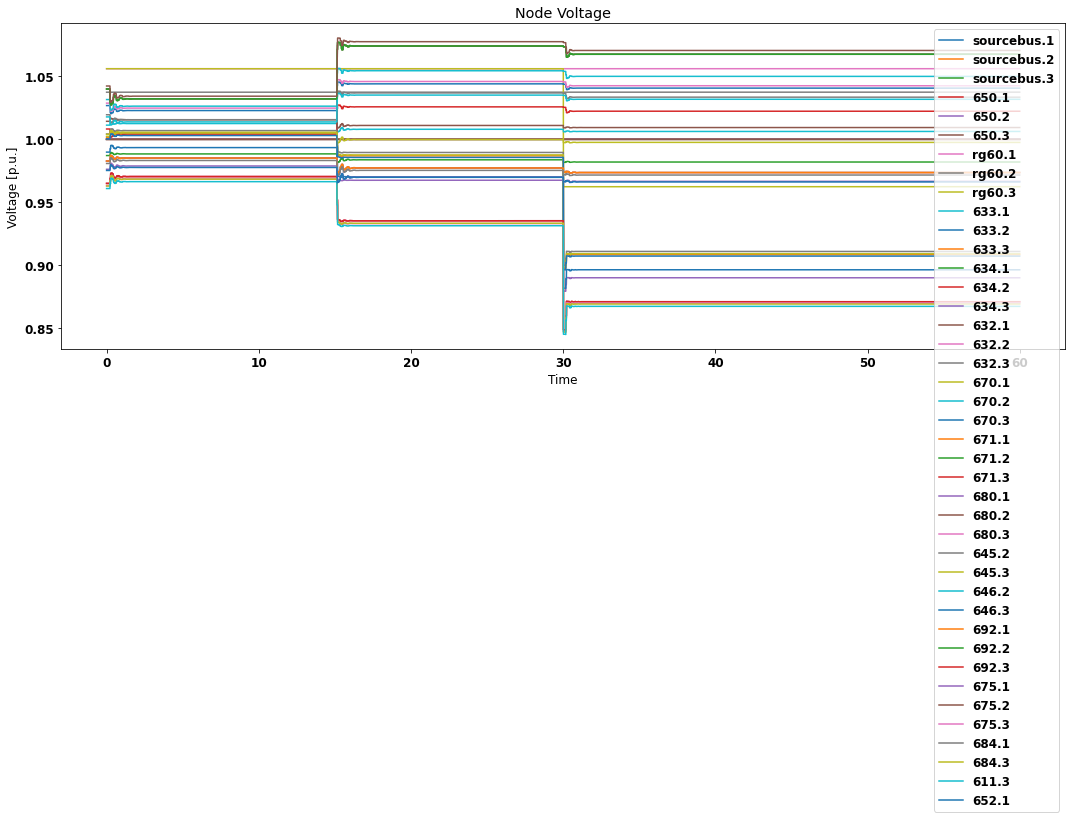

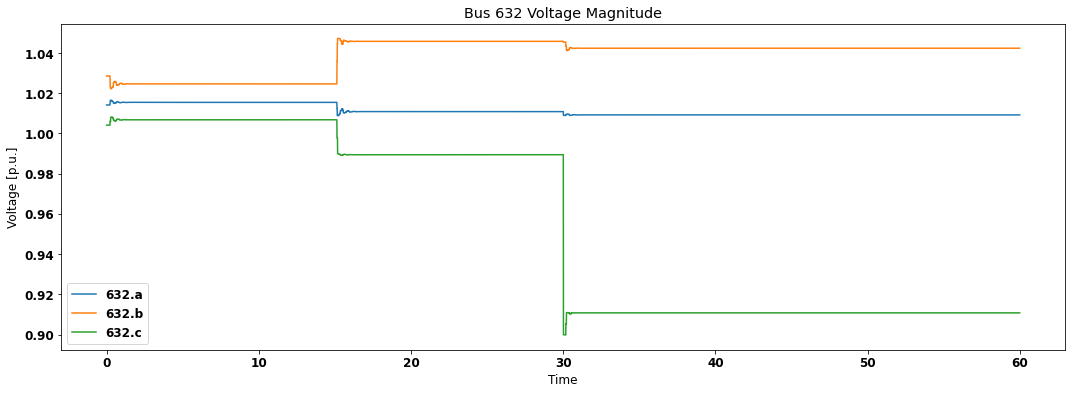

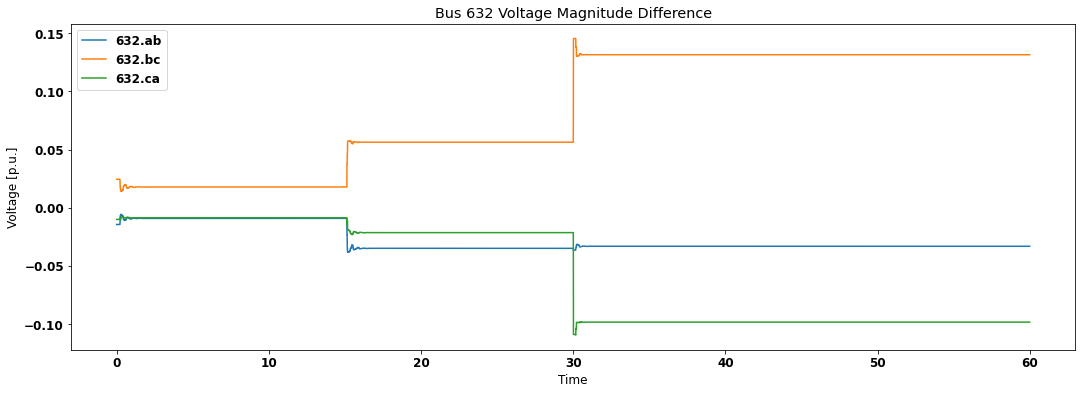

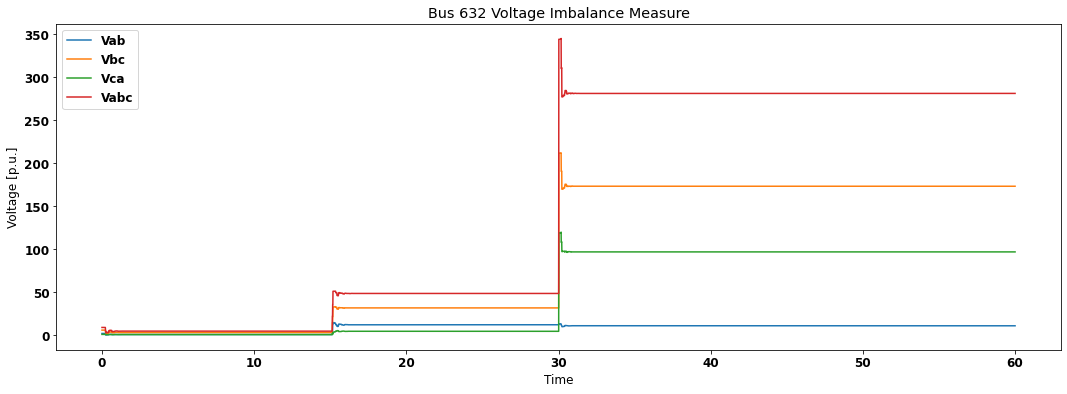

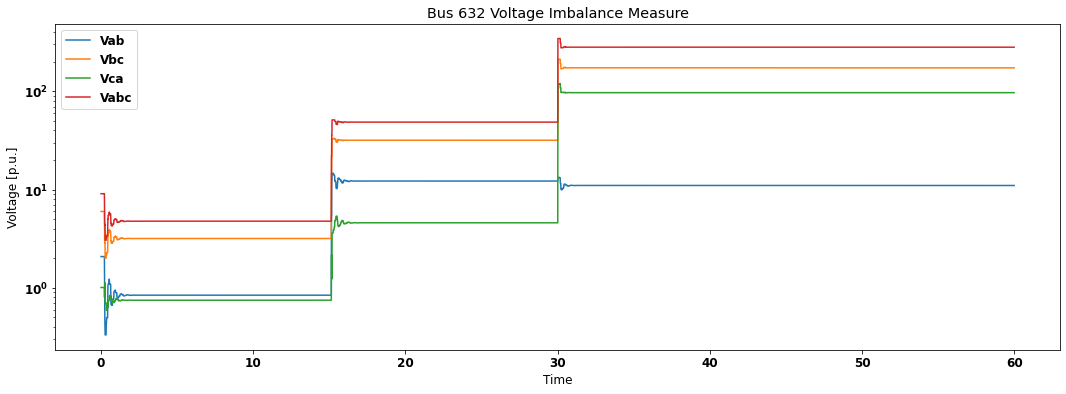

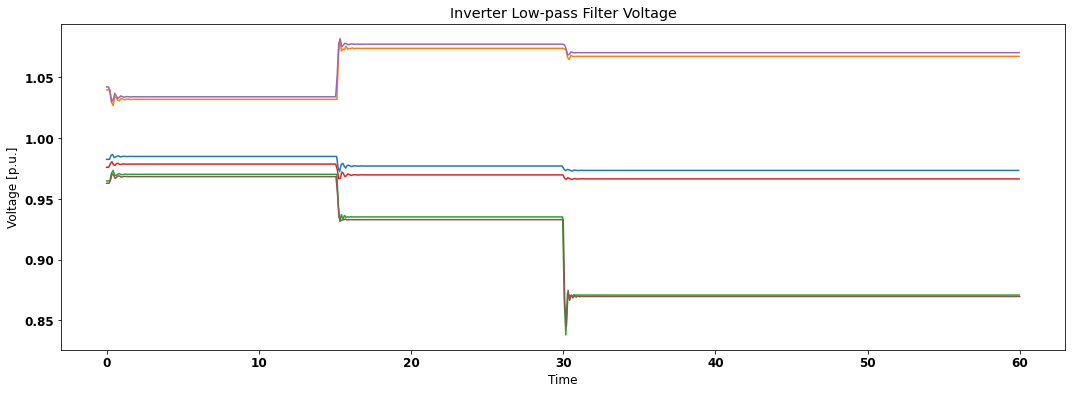

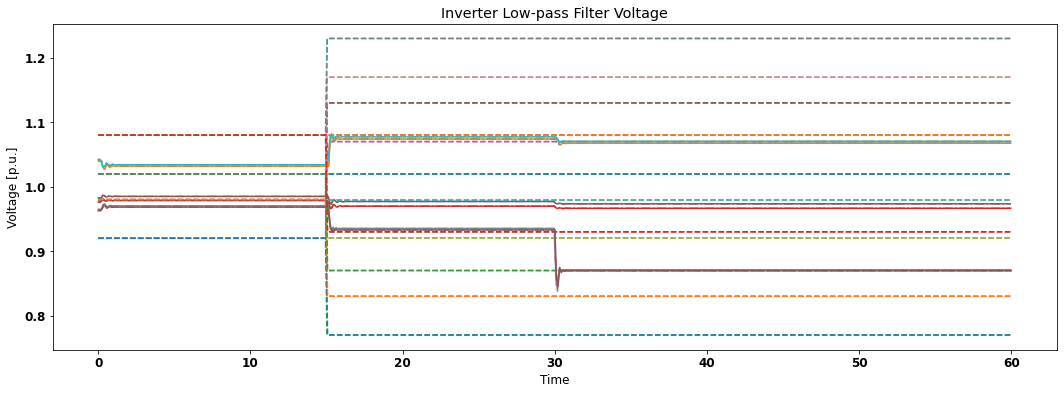

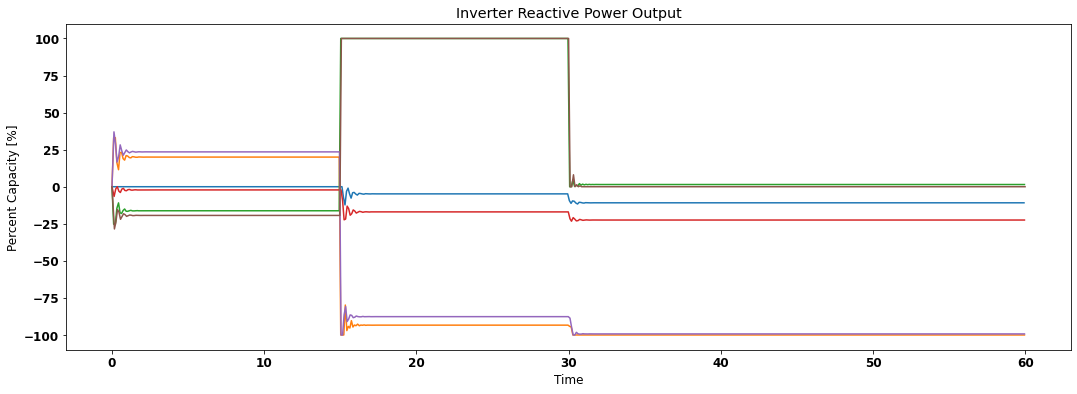

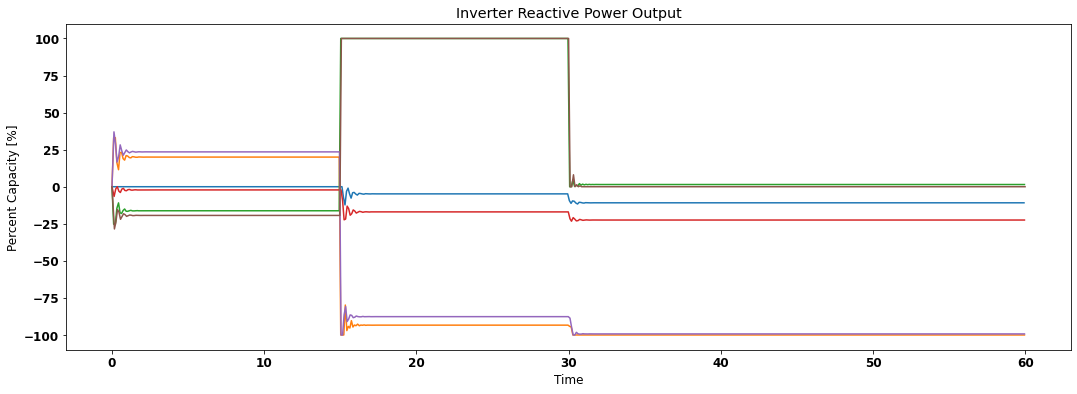

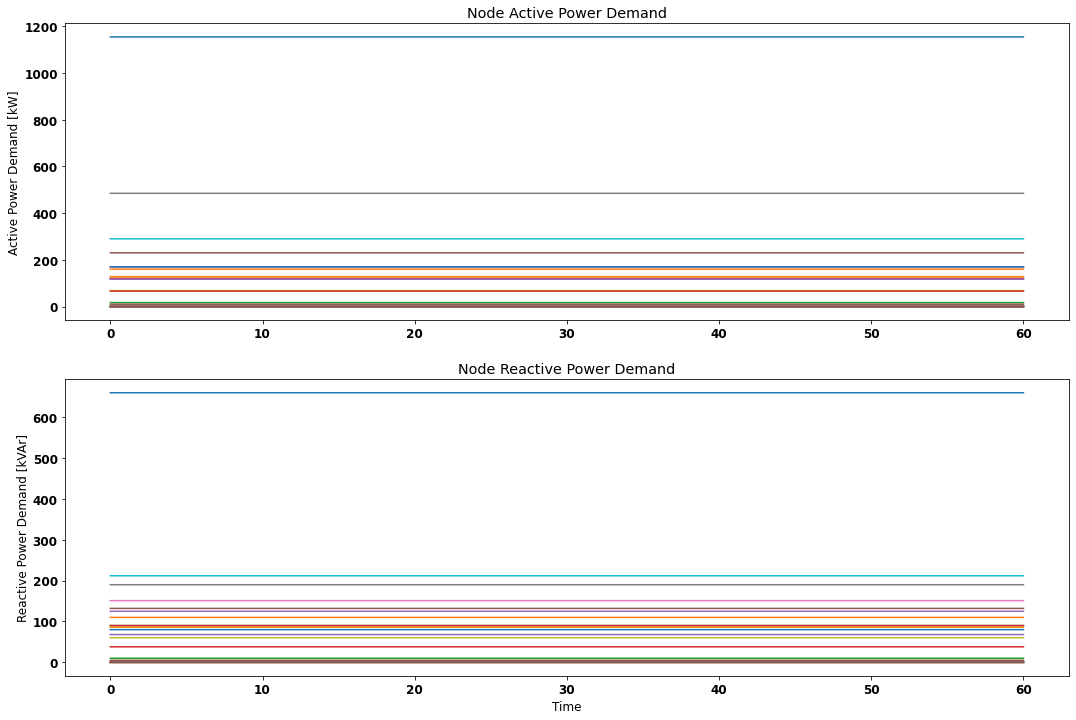

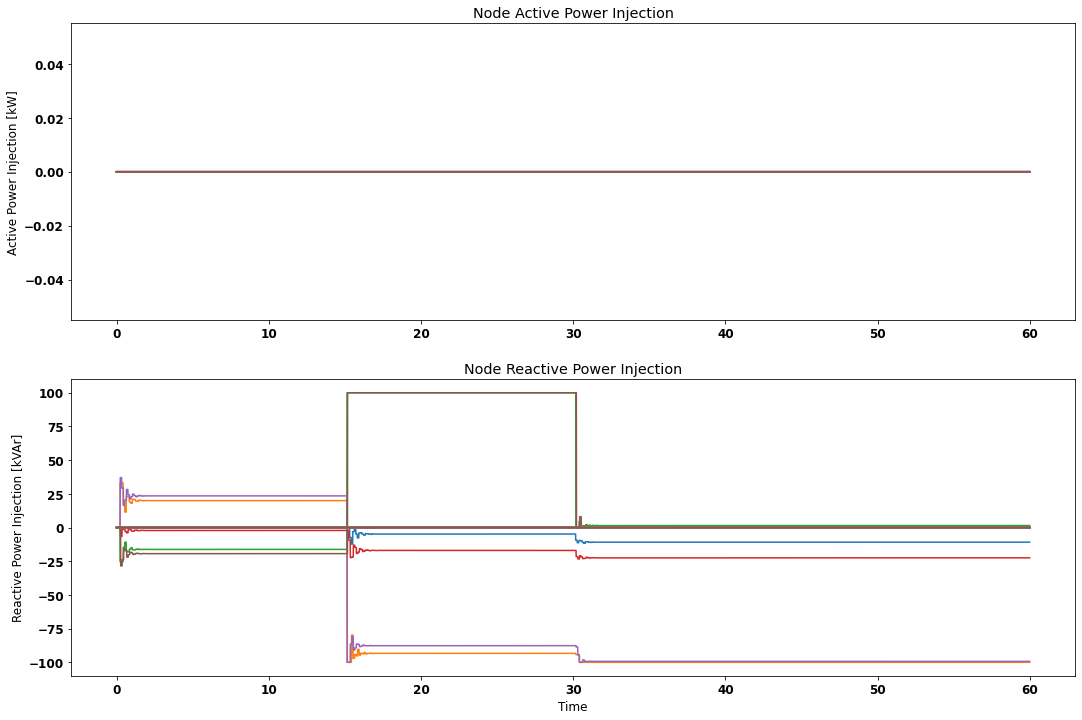

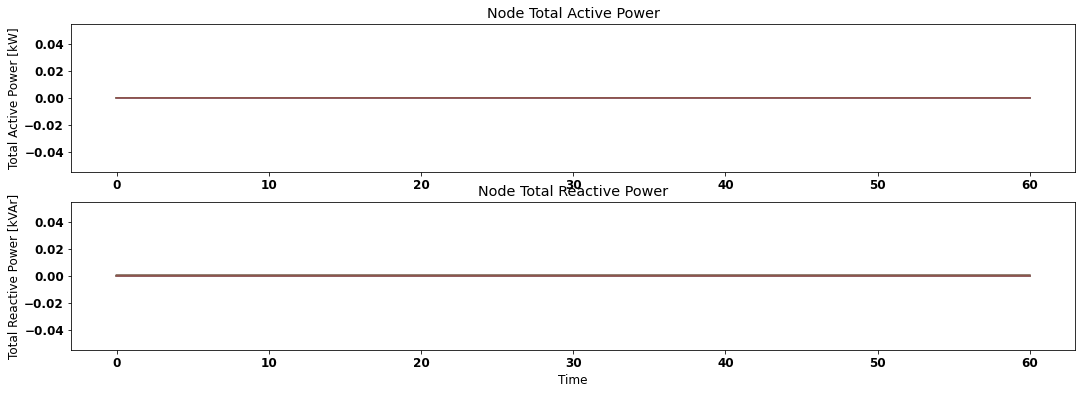

####################
####################
####################
####################
####################
####################


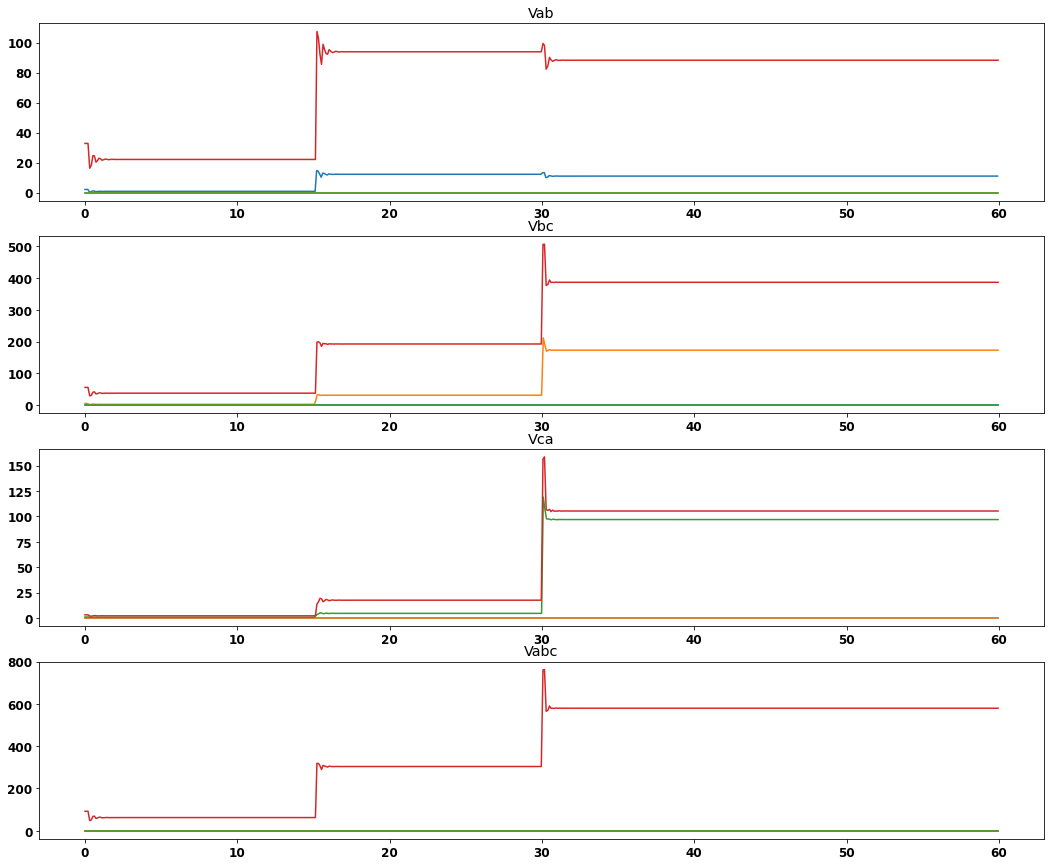

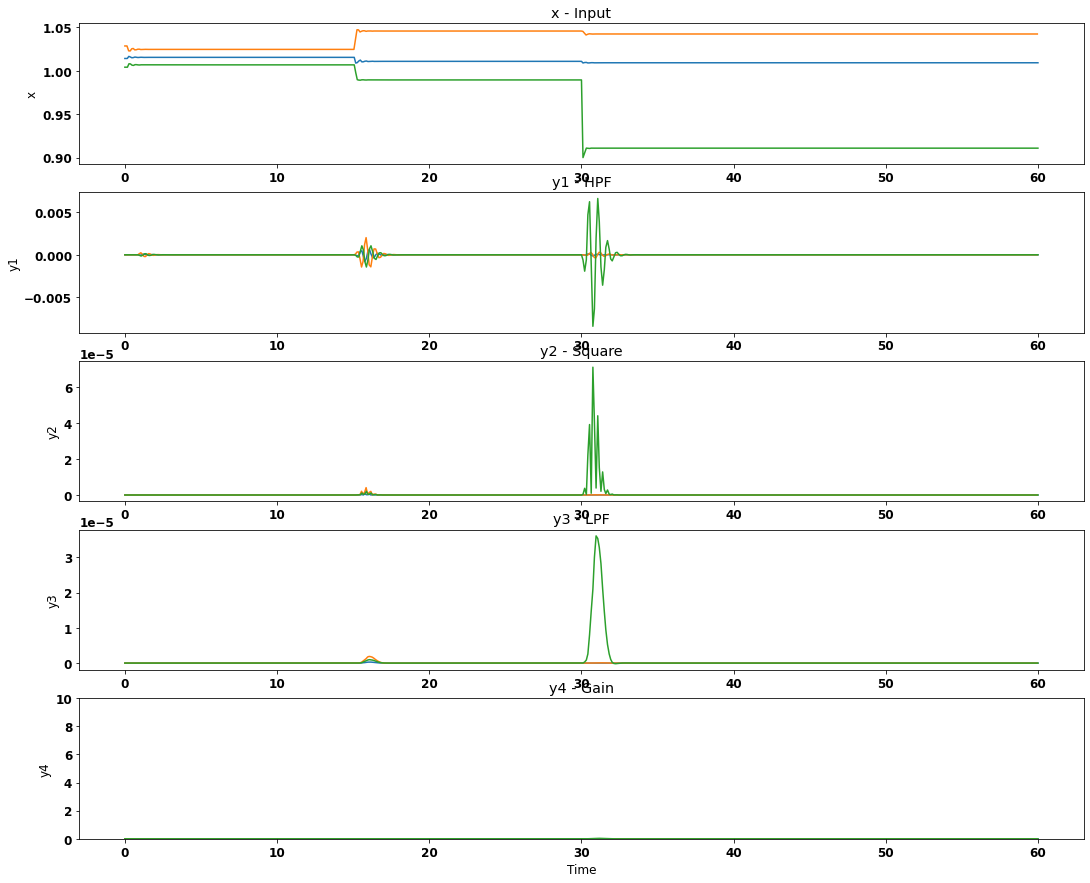

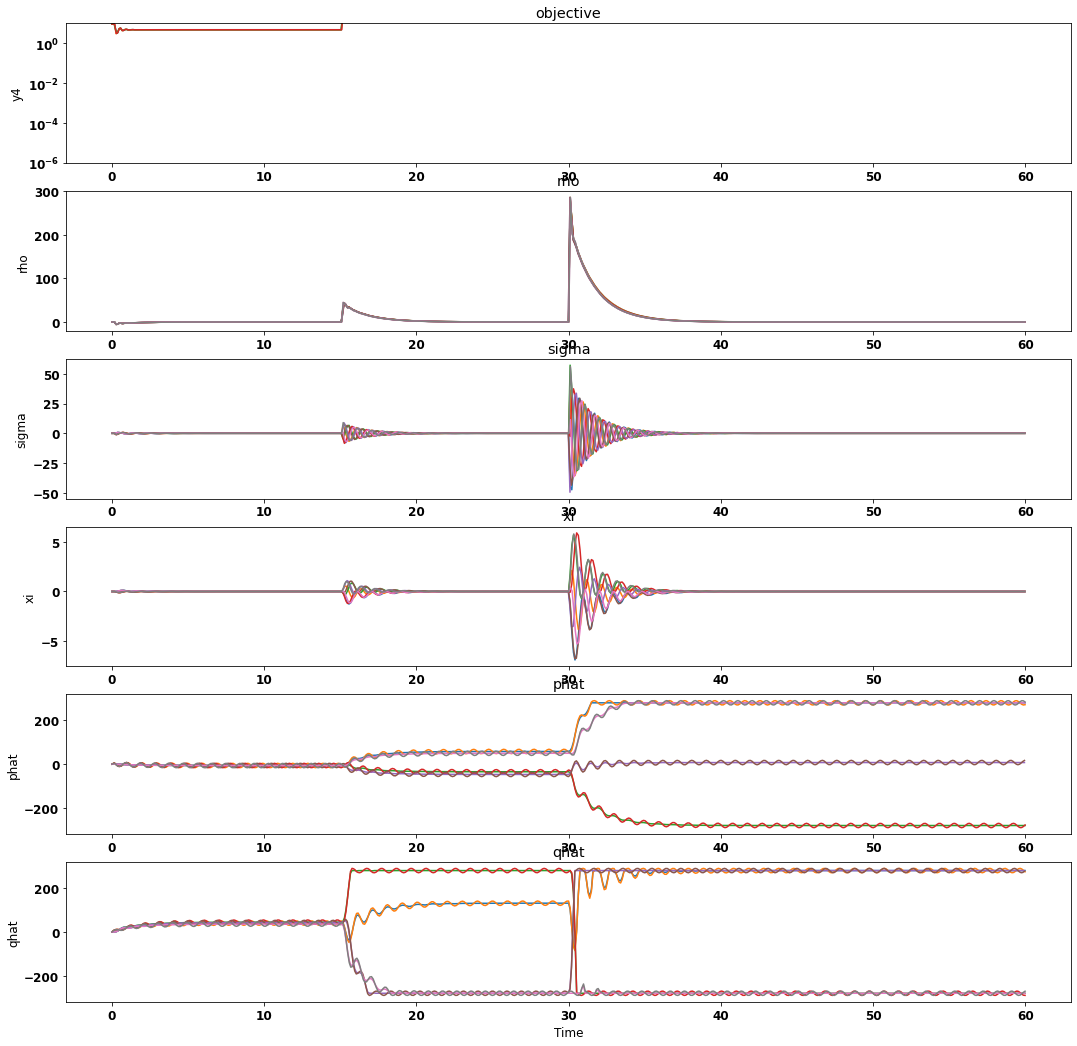

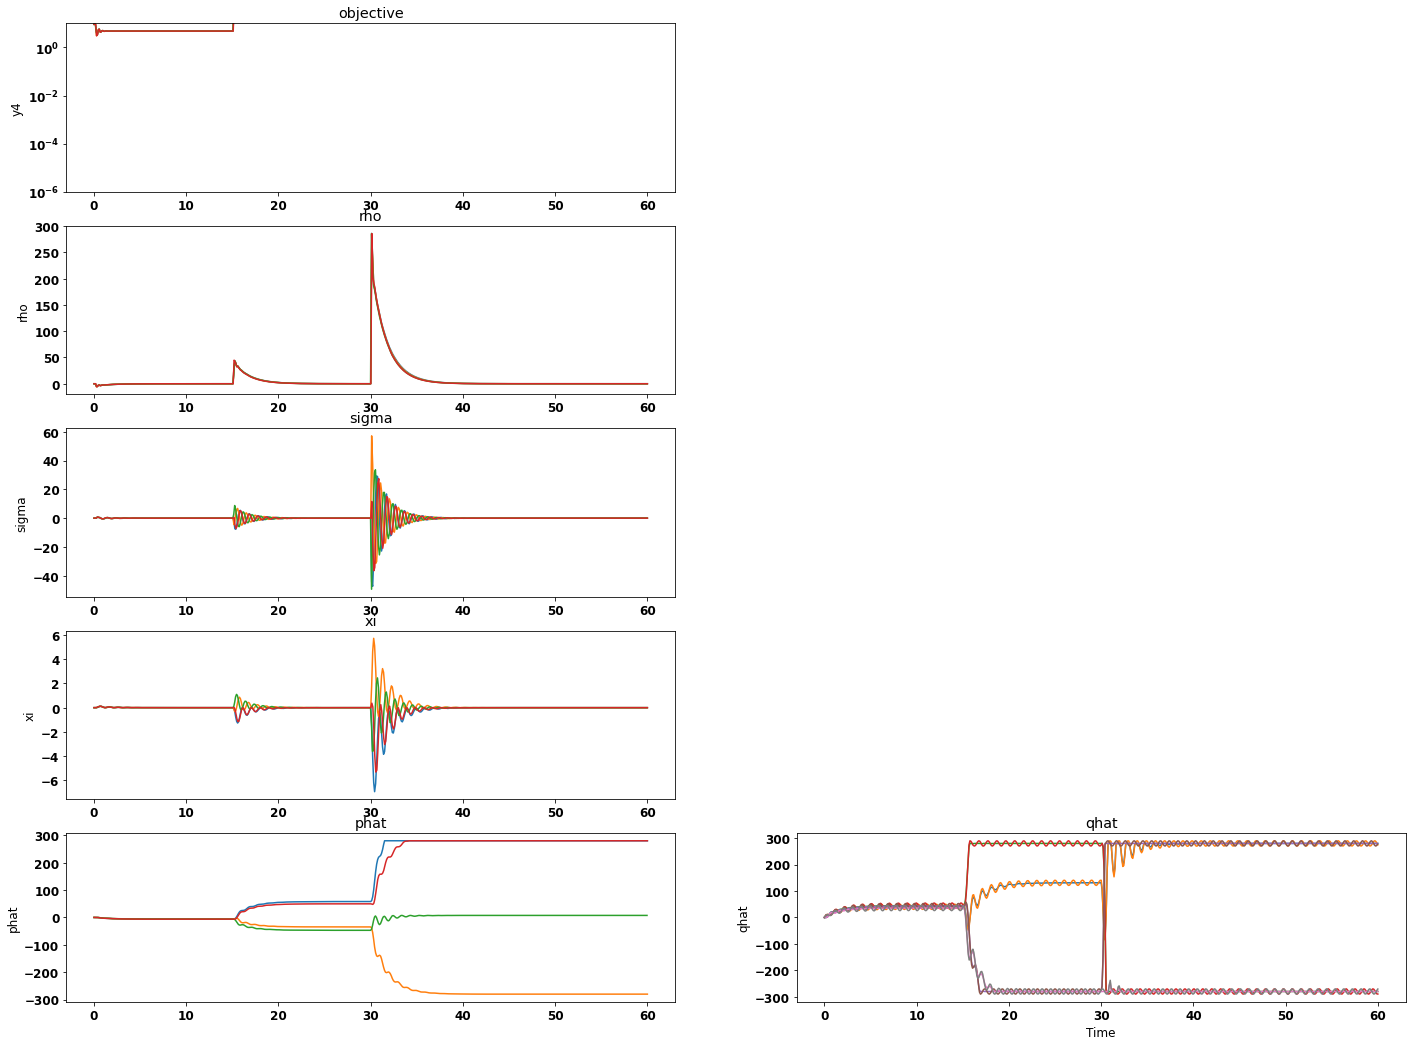

In [6]:
font = {'weight':'bold', 'size':12}
plt.rc('font', **font)

##################################################
# Bus Voltage
##################################################

fig = plt.figure(figsize=[18,6])
for k1 in range(len(AllBuses)):
    dss.Circuit.SetActiveBus(AllBuses[k1])
    for ph in dss.Bus.Nodes():
        plt.plot(time,AllBusVoltage[:,ph-1,k1],label=AllBuses[k1]+'.'+str(ph))
plt.title('Node Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.legend()
plt.show()

fig = plt.figure(figsize=[18,6])
# plt.plot(time,AllBusVoltage[:,0,AllBuses.index('632')],label='632'+'.'+str(1))
# plt.plot(time,AllBusVoltage[:,1,AllBuses.index('632')],label='632'+'.'+str(2))
# plt.plot(time,AllBusVoltage[:,2,AllBuses.index('632')],label='632'+'.'+str(3))
plt.plot(time,AllBusVoltage[:,0,AllBuses.index('632')],label='632'+'.a')
plt.plot(time,AllBusVoltage[:,1,AllBuses.index('632')],label='632'+'.b')
plt.plot(time,AllBusVoltage[:,2,AllBuses.index('632')],label='632'+'.c')
plt.title('Bus 632 Voltage Magnitude')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.legend()
plt.show()

# # fig.savefig('/home/michael/Desktop/temp/noreg_nocon_632_voltage.png')

# fig = plt.figure(figsize=[18,6])
# plt.plot(time,AllBusVoltage[:,0,AllBuses.index('670')],label='670'+'.'+str(1))
# plt.plot(time,AllBusVoltage[:,1,AllBuses.index('670')],label='670'+'.'+str(2))
# plt.plot(time,AllBusVoltage[:,2,AllBuses.index('670')],label='670'+'.'+str(3))
# plt.title('Node Voltage')
# plt.xlabel('Time')
# plt.ylabel('Voltage [p.u.]')
# plt.legend()
# plt.show()

fig = plt.figure(figsize=[18,6])
# plt.plot(time,AllBusVoltage[:,0,AllBuses.index('632')],label='632'+'.'+str(1))
# plt.plot(time,AllBusVoltage[:,1,AllBuses.index('632')],label='632'+'.'+str(2))
# plt.plot(time,AllBusVoltage[:,2,AllBuses.index('632')],label='632'+'.'+str(3))
plt.plot(time,AllBusVoltage[:,0,AllBuses.index('632')] - AllBusVoltage[:,1,AllBuses.index('632')],label='632'+'.ab')
plt.plot(time,AllBusVoltage[:,1,AllBuses.index('632')] - AllBusVoltage[:,2,AllBuses.index('632')],label='632'+'.bc')
plt.plot(time,AllBusVoltage[:,2,AllBuses.index('632')] - AllBusVoltage[:,0,AllBuses.index('632')],label='632'+'.ca')
plt.title('Bus 632 Voltage Magnitude Difference')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.legend()
plt.show()

fig = plt.figure(figsize=[18,6])
# plt.plot(time,AllBusVoltage[:,0,AllBuses.index('632')],label='632'+'.'+str(1))
# plt.plot(time,AllBusVoltage[:,1,AllBuses.index('632')],label='632'+'.'+str(2))
# plt.plot(time,AllBusVoltage[:,2,AllBuses.index('632')],label='632'+'.'+str(3))
plt.plot(time,Vimb[:,0],label='Vab')
plt.plot(time,Vimb[:,1],label='Vbc')
plt.plot(time,Vimb[:,2],label='Vca')
plt.plot(time,Vimb[:,3],label='Vabc')
plt.title('Bus 632 Voltage Imbalance Measure')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.legend()
plt.show()

fig = plt.figure(figsize=[18,6])
# plt.plot(time,AllBusVoltage[:,0,AllBuses.index('632')],label='632'+'.'+str(1))
# plt.plot(time,AllBusVoltage[:,1,AllBuses.index('632')],label='632'+'.'+str(2))
# plt.plot(time,AllBusVoltage[:,2,AllBuses.index('632')],label='632'+'.'+str(3))
plt.semilogy(time,Vimb[:,0],label='Vab')
plt.semilogy(time,Vimb[:,1],label='Vbc')
plt.semilogy(time,Vimb[:,2],label='Vca')
plt.semilogy(time,Vimb[:,3],label='Vabc')
plt.title('Bus 632 Voltage Imbalance Measure')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.legend()
plt.show()

##################################################
# Inverters
##################################################

fig = plt.figure(figsize=[18,6])
for k1 in range(0,len(inverterlist)):
#     plt.plot(inverterlist[k1].Vmeas[:])
    # plt.plot(inverterlist[k1].timeop,inverterlist[k1].VBPhist[:],'--')
    # plt.plot(inverterlist[k1].timeop,inverterlist[k1].Vmeas[:],'-.')
    plt.plot(inverterlist[k1].timeop,inverterlist[k1].Vlp[:])
# plt.ylim([0.85, 1.05])
plt.title('Inverter Low-pass Filter Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.show()

fig = plt.figure(figsize=[18,6])
for k1 in range(0,len(inverterlist)):
#     plt.plot(inverterlist[k1].Vmeas[:])
    plt.plot(inverterlist[k1].timeop,inverterlist[k1].VBPhist[:],'--')
    plt.plot(inverterlist[k1].timeop,inverterlist[k1].Vmeas[:],'-.')
    plt.plot(inverterlist[k1].timeop,inverterlist[k1].Vlp[:])
# plt.ylim([0.85, 1.05])
plt.title('Inverter Low-pass Filter Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.show()

fig = plt.figure(figsize=[18,6])
for k1 in range(0,len(inverterlist)):
    plt.plot(inverterlist[k1].timeop,inverterlist[k1].reactive_power)
# plt.ylim([-100, 100])
plt.title('Inverter Reactive Power Output')
plt.xlabel('Time')
plt.ylabel('Percent Capacity [%]')
plt.show()

fig = plt.figure(figsize=[18,6])
for k1 in range(0,len(inverterlist)):
    plt.plot(inverterlist[k1].timeop,inverterlist[k1].qin)
# plt.ylim([-100, 100])
plt.title('Inverter Reactive Power Output')
plt.xlabel('Time')
plt.ylabel('Percent Capacity [%]')
plt.show()

##################################################
# Bus Power
##################################################

fig = plt.figure(figsize=[18,12])
plt.subplot(2,1,1)
plt.plot(time,PloadTS[:,:])
plt.title('Node Active Power Demand')
# plt.xlabel('Time')
plt.ylabel('Active Power Demand [kW]')
plt.subplot(2,1,2)
plt.plot(time,QloadTS[:,:])
plt.title('Node Reactive Power Demand')
plt.xlabel('Time')
plt.ylabel('Reactive Power Demand [kVAr]')
plt.show()

fig = plt.figure(figsize=[18,12])
plt.subplot(2,1,1)
plt.plot(time,PinvTS[:,:])
plt.title('Node Active Power Injection')
# plt.xlabel('Time')
plt.ylabel('Active Power Injection [kW]')
plt.subplot(2,1,2)
plt.plot(time,QinvTS[:,:])
plt.title('Node Reactive Power Injection')
plt.xlabel('Time')
plt.ylabel('Reactive Power Injection [kVAr]')
plt.show()

fig = plt.figure(figsize=[18,6])
plt.subplot(2,1,1)
plt.plot(time,PtotalTS[:,:])
plt.title('Node Total Active Power')
# plt.xlabel('Time')
plt.ylabel('Total Active Power [kW]')
plt.subplot(2,1,2)
plt.plot(time,QtotalTS[:,:])
plt.title('Node Total Reactive Power')
plt.xlabel('Time')
plt.ylabel('Total Reactive Power [kVAr]')
plt.show()

##################################################
# Voltage oscillation observer
##################################################

print('####################')
print('####################')
print('####################')

fig = plt.figure(figsize=[18,15])
plt.subplot(4,1,1)
for vio in violist:
    plt.plot(vio.timeop,vio.Vimb[:,0])
plt.title('Vab')
plt.subplot(4,1,2)
for vio in violist:
    plt.plot(vio.timeop,vio.Vimb[:,1])
plt.title('Vbc')
plt.subplot(4,1,3)
for vio in violist:
    plt.plot(vio.timeop,vio.Vimb[:,2])
plt.title('Vca')
plt.subplot(4,1,4)
for vio in violist:
    plt.plot(vio.timeop,vio.Vimb[:,3])
plt.title('Vabc')

##################################################
# Voltage oscillation observer
##################################################

print('####################')
print('####################')
print('####################')

fig = plt.figure(figsize=[18,15])
plt.subplot(5,1,1)
for voo in voolist:
    plt.plot(voo.timeop,voo.x)
plt.title('x - Input')
# plt.xlabel('Time')
plt.ylabel('x')
plt.subplot(5,1,2)
for voo in voolist:
    plt.plot(voo.timeop,voo.y1)
plt.title('y1 - HPF')
# plt.xlabel('Time')
plt.ylabel('y1')
plt.subplot(5,1,3)
for voo in voolist:
    plt.plot(voo.timeop,voo.y2)
plt.title('y2 - Square')
plt.ylabel('y2')
plt.subplot(5,1,4)
for voo in voolist:
    plt.plot(voo.timeop,voo.y3)
plt.title('y3 - LPF')
plt.ylabel('y3')
plt.subplot(5,1,5)
for voo in voolist:
    plt.plot(voo.timeop,voo.y4)
plt.title('y4 - Gain')
plt.xlabel('Time')
plt.ylabel('y4')
plt.ylim([1e-12, 1e+1])
plt.show()

fig = plt.figure(figsize=[18,18])
plt.subplot(6,1,1)
for k1 in range(len(esclist)):
    plt.semilogy(esclist[k1].timeop,esclist[k1].psi)
plt.title('objective')
plt.ylabel('y4')
plt.ylim([1e-6, 1e+1])
plt.subplot(6,1,2)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].rhop)
    plt.plot(esclist[k1].timeop,esclist[k1].rhoq)
plt.title('rho')
plt.ylabel('rho')
plt.subplot(6,1,3)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].sigmap)
    plt.plot(esclist[k1].timeop,esclist[k1].sigmaq)
plt.title('sigma')
plt.ylabel('sigma')
plt.subplot(6,1,4)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].xip)
    plt.plot(esclist[k1].timeop,esclist[k1].xiq)
plt.title('xi')
plt.ylabel('xi')
plt.subplot(6,1,5)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].phat)
    plt.plot(esclist[k1].timeop,esclist[k1].p)
plt.title('phat')
plt.ylabel('phat')
plt.subplot(6,1,6)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].qhat)
    plt.plot(esclist[k1].timeop,esclist[k1].q)
plt.title('qhat')
plt.xlabel('Time')
plt.ylabel('qhat')
plt.show()

fig = plt.figure(figsize=[24,18])
plt.subplot(5,2,1)
for k1 in range(len(esclist)):
    plt.semilogy(esclist[k1].timeop,esclist[k1].psi)
plt.title('objective')
plt.ylabel('y4')
plt.ylim([1e-6, 1e+1])
plt.subplot(5,2,3)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].rhop)
    # plt.plot(esclist[k1].timeop,esclist[k1].rhoq)
plt.title('rho')
plt.ylabel('rho')
plt.subplot(5,2,5)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].sigmap)
    # plt.plot(esclist[k1].timeop,esclist[k1].sigmaq)
plt.title('sigma')
plt.ylabel('sigma')
plt.subplot(5,2,7)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].xip)
    # plt.plot(esclist[k1].timeop,esclist[k1].xiq)
plt.title('xi')
plt.ylabel('xi')
plt.subplot(5,2,9)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].phat)
    # plt.plot(esclist[k1].timeop,esclist[k1].p)
plt.title('phat')
plt.ylabel('phat')
plt.subplot(5,2,10)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].qhat)
    plt.plot(esclist[k1].timeop,esclist[k1].q)
plt.title('qhat')
plt.xlabel('Time')
plt.ylabel('qhat')
plt.show()


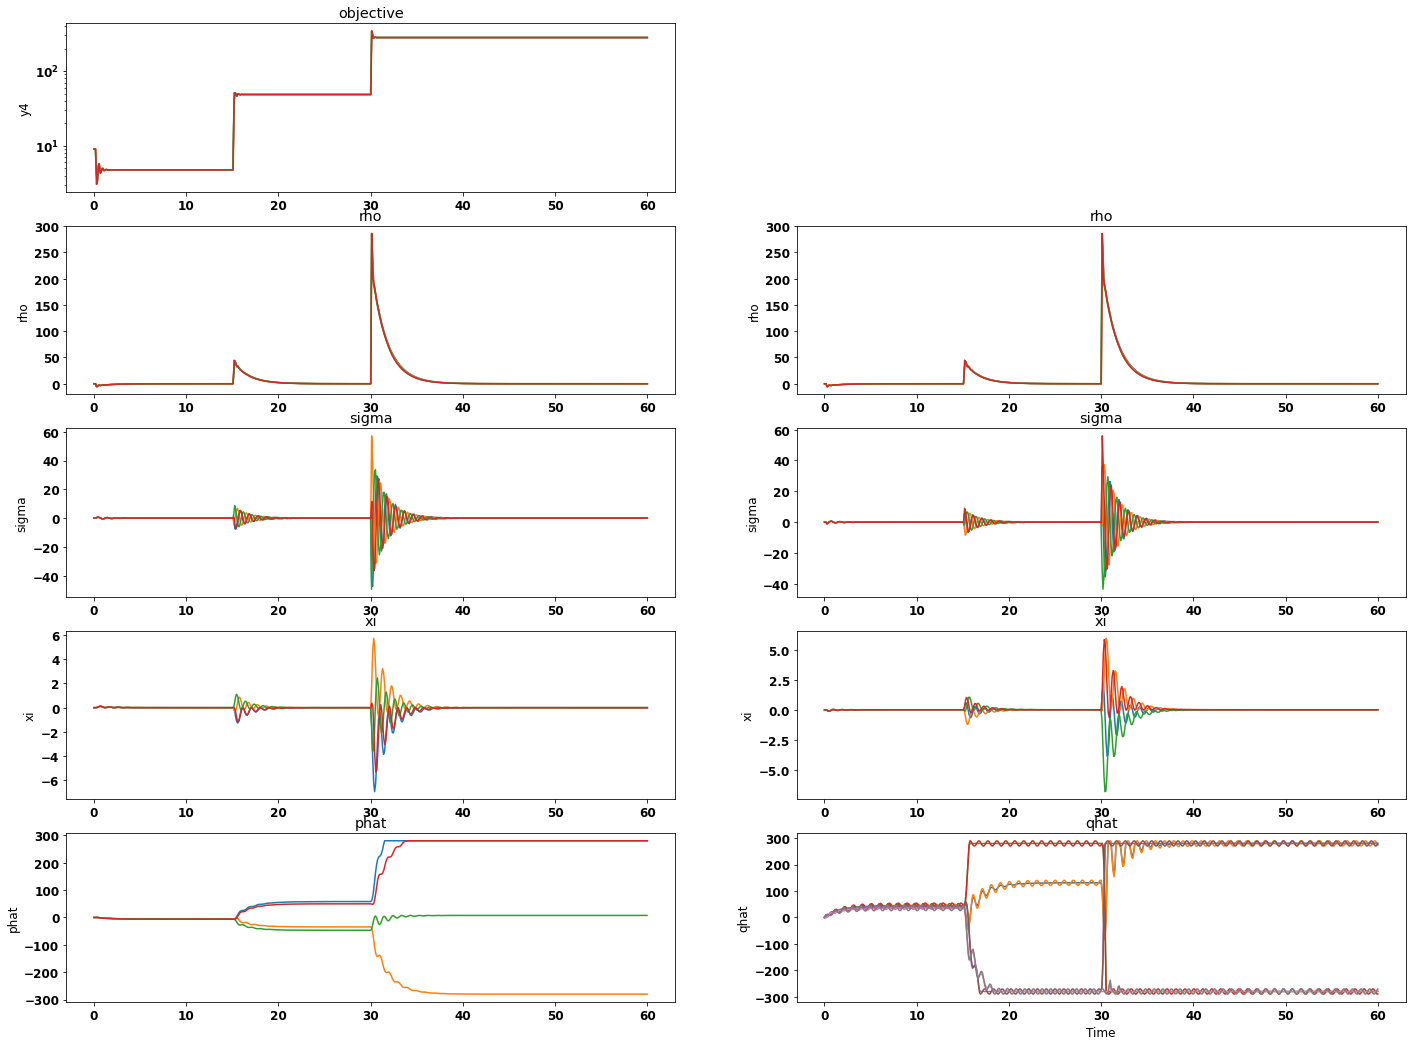

In [7]:
fig = plt.figure(figsize=[24,18])
plt.subplot(5,2,1)
for k1 in range(len(esclist)):
    plt.semilogy(esclist[k1].timeop,esclist[k1].psi)
plt.title('objective')
plt.ylabel('y4')
# plt.ylim([1e-5, 1e-1])

plt.subplot(5,2,3)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].rhop)
    # plt.plot(esclist[k1].timeop,esclist[k1].rhoq)
plt.title('rho')
plt.ylabel('rho')
plt.subplot(5,2,5)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].sigmap)
    # plt.plot(esclist[k1].timeop,esclist[k1].sigmaq)
plt.title('sigma')
plt.ylabel('sigma')
plt.subplot(5,2,7)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].xip)
    # plt.plot(esclist[k1].timeop,esclist[k1].xiq)
plt.title('xi')
plt.ylabel('xi')
plt.subplot(5,2,9)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].phat)
    # plt.plot(esclist[k1].timeop,esclist[k1].p)
plt.title('phat')
plt.ylabel('phat')

plt.subplot(5,2,4)
for k1 in range(len(esclist)):
    # plt.plot(esclist[k1].timeop,esclist[k1].rhop)
    plt.plot(esclist[k1].timeop,esclist[k1].rhoq)
plt.title('rho')
plt.ylabel('rho')
plt.subplot(5,2,6)
for k1 in range(len(esclist)):
    # plt.plot(esclist[k1].timeop,esclist[k1].sigmap)
    plt.plot(esclist[k1].timeop,esclist[k1].sigmaq)
plt.title('sigma')
plt.ylabel('sigma')
plt.subplot(5,2,8)
for k1 in range(len(esclist)):
    # plt.plot(esclist[k1].timeop,esclist[k1].xip)
    plt.plot(esclist[k1].timeop,esclist[k1].xiq)
plt.title('xi')
plt.ylabel('xi')
plt.subplot(5,2,10)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].qhat)
    plt.plot(esclist[k1].timeop,esclist[k1].q)
plt.title('qhat')
plt.xlabel('Time')
plt.ylabel('qhat')
plt.show()

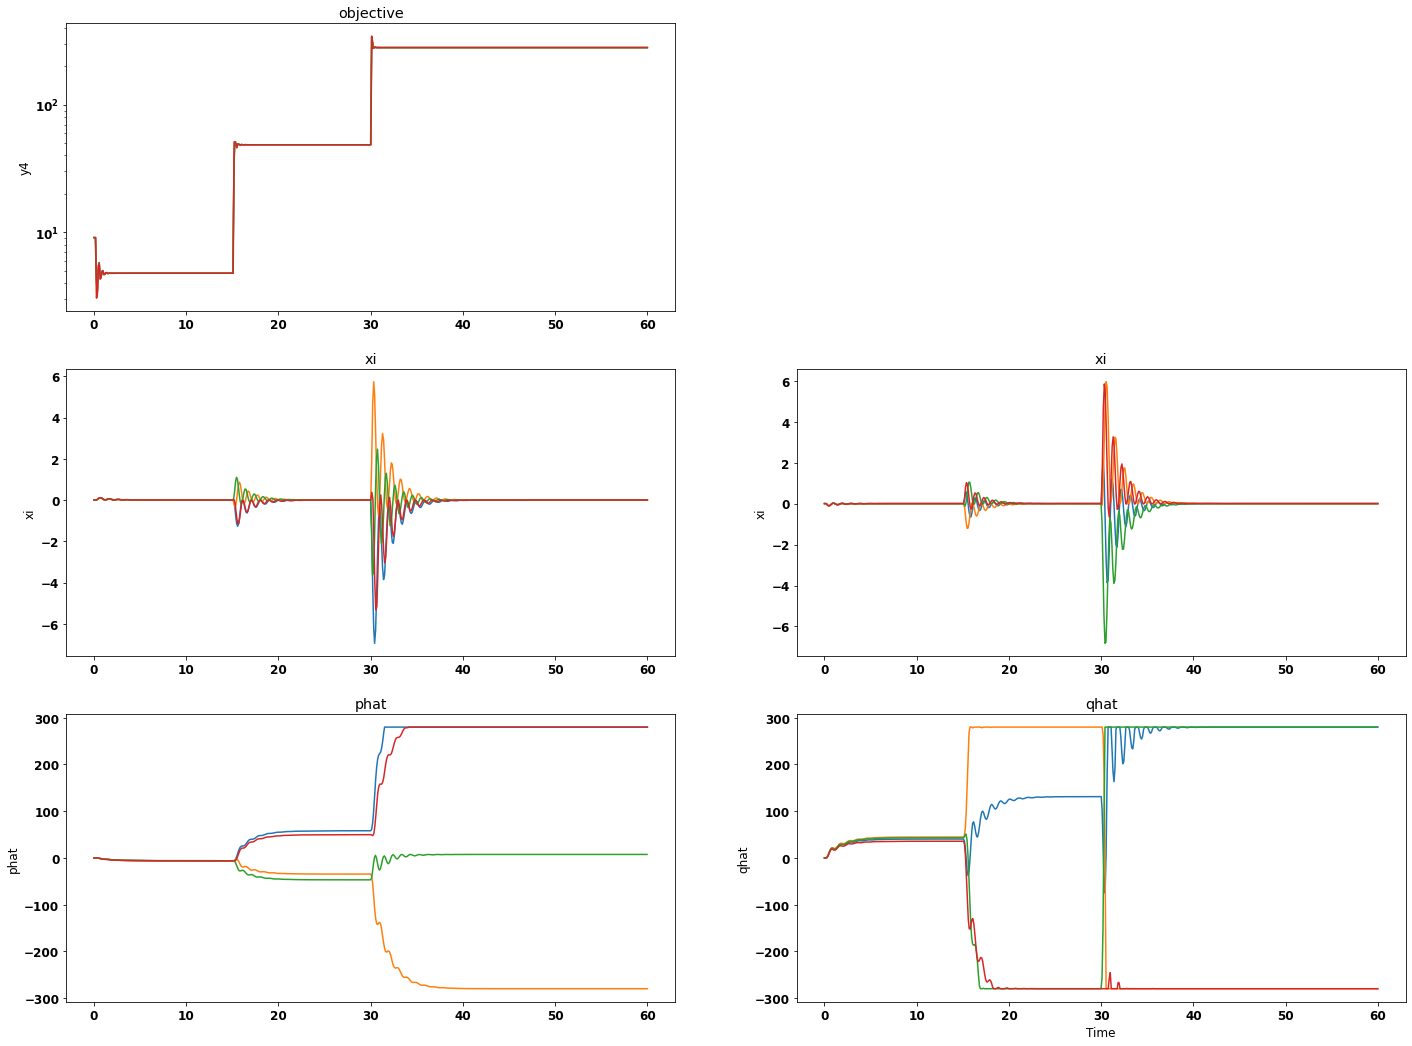

In [8]:
fig = plt.figure(figsize=[24,18])
plt.subplot(3,2,1)
for k1 in range(len(esclist)):
    plt.semilogy(esclist[k1].timeop,esclist[k1].psi)
plt.title('objective')
plt.ylabel('y4')
# plt.ylim([1e-5, 1e-1])

plt.subplot(3,2,3)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].xip)
    # plt.plot(esclist[k1].timeop,esclist[k1].xiq)
plt.title('xi')
plt.ylabel('xi')
plt.subplot(3,2,5)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].phat)
    # plt.plot(esclist[k1].timeop,esclist[k1].p)
plt.title('phat')
plt.ylabel('phat')

plt.subplot(3,2,4)
for k1 in range(len(esclist)):
    # plt.plot(esclist[k1].timeop,esclist[k1].xip)
    plt.plot(esclist[k1].timeop,esclist[k1].xiq)
plt.title('xi')
plt.ylabel('xi')
plt.subplot(3,2,6)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].qhat)
    # plt.plot(esclist[k1].timeop,esclist[k1].q)
plt.title('qhat')
plt.xlabel('Time')
plt.ylabel('qhat')
plt.show()

In [9]:
for k1 in range(len(dss.Loads.AllNames())):
    dss.Loads.Name(dss.Loads.AllNames()[k1])
    dss.CktElement.AllPropertyNames()
    print(dss.Loads.Name())
    print(dss.Loads.IsDelta())
    print(dss.CktElement.BusNames()[0].split('.',1))
    print(dss.Loads.IsDelta())
    print(dss.CktElement.NodeOrder())    
    print(dss.Loads.kV())
    print(dss.Loads.kVABase())
    print(dss.Loads.kW())
    print(dss.Loads.kvar()) 
    print(dss.CktElement.Powers())
    print('')

load_671
True
['671', '1.2.3']
True
[1, 2, 3]
4.16
1330.2725284692608
1155.0
660.0
[389.41368998885946, 200.30416955691922, 417.6249311436597, 251.1482032714082, 335.1830020349487, 201.24569755308286]

load_634a
False
['634', '1']
False
[1, 0]
0.277
194.164878389476
160.0
110.0
[160.0, 110.00000000000001, 0.0, 0.0]

load_634b
False
['634', '2']
False
[2, 0]
0.277
150.0
120.0
90.0
[120.0, 90.0, 0.0, 0.0]

load_634c
False
['634', '3']
False
[3, 0]
0.277
150.0
120.0
90.0
[104.6311837362164, 78.47338780216229, 0.0, 0.0]

load_645
False
['645', '2']
False
[2, 0]
2.4
211.00947846009194
170.0
125.0
[170.0, 125.0, 0.0, 0.0]

load_646
True
['646', '2.3']
True
[2, 3]
4.16
265.18672666632466
230.0
132.0
[152.8295329067834, 4.768779878659756, 62.708109954202094, 118.9310847198189]

load_692
True
['692', '3.1']
True
[3, 1]
4.16
227.37853900489378
170.0
151.0
[110.26274489674648, 21.878318349390987, 46.01013670260856, 116.9287706006244]

load_675a
False
['675', '1']
False
[1, 0]
2.4
520.888663727672

In [10]:
print(dss.Circuit.AllBusNames())
AllBusVoltage[0,:,1]

['sourcebus', '650', 'rg60', '633', '634', '632', '670', '671', '680', '645', '646', '692', '675', '684', '611', '652']


array([0.99981064, 0.99986995, 0.99983098])

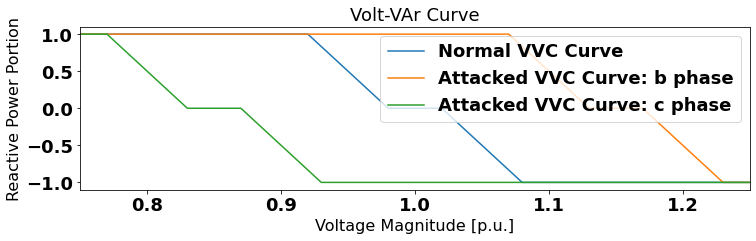

In [19]:
fig = plt.figure(figsize=[12,3])

# x = inverter.VBPhist[1,:]
# x = np.insert(x,0,0.94)
# x = np.insert(x,len(x),1.06)
# print(x)

x = inverterlist[0].VBPhist[0,:]
x = np.insert(x,0,0.5)
x = np.insert(x,len(x),1.5)
plt.plot(x,np.array([1, 1, 0, 0, -1, -1]),label='Normal VVC Curve')
x = inverterlist[1].VBPhist[201,:]
x = np.insert(x,0,0.5)
x = np.insert(x,len(x),1.5)
# x = x - 0.05
plt.plot(x,np.array([1, 1, 0, 0, -1, -1]),label='Attacked VVC Curve: b phase')
x = inverterlist[2].VBPhist[201,:]
x = np.insert(x,0,0.5)
x = np.insert(x,len(x),1.5)
# x = x + 0.05
plt.plot(x,np.array([1, 1, 0, 0, -1, -1]),label='Attacked VVC Curve: c phase')
plt.xlim([0.75, 1.25])

plt.title('Volt-VAr Curve',fontsize=18)
plt.xlabel('Voltage Magnitude [p.u.]',fontsize=16)
plt.ylabel('Reactive Power',fontsize=16)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

fig.savefig('/home/michael/Desktop/temp/imbalance_VVC.png')

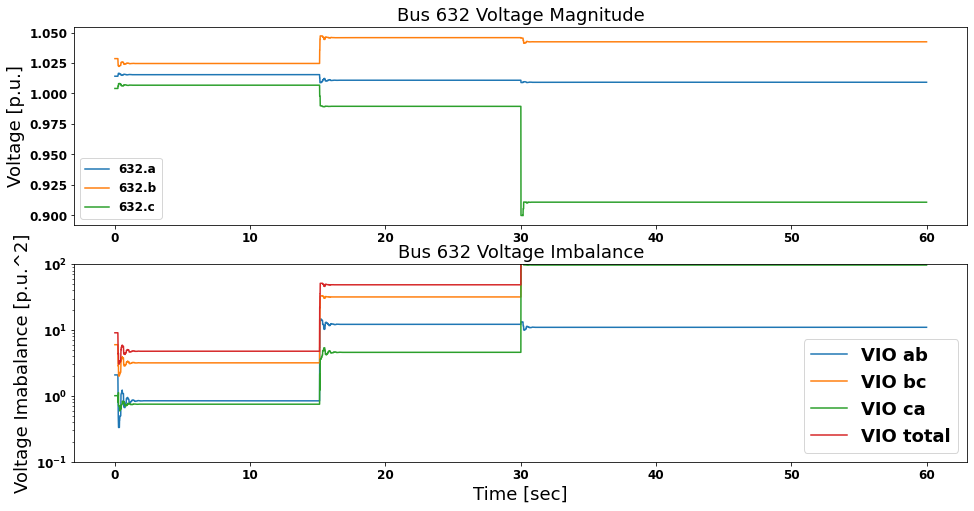

In [12]:
fig = plt.figure(figsize=[12,6])
plt.subplot(2,1,1)
plt.plot(time,AllBusVoltage[:,0,AllBuses.index('632')],label='632'+'.a')
plt.plot(time,AllBusVoltage[:,1,AllBuses.index('632')],label='632'+'.b')
plt.plot(time,AllBusVoltage[:,2,AllBuses.index('632')],label='632'+'.c')
plt.title('Bus 632 Voltage Magnitude',fontsize=18)
plt.ylabel('Voltage [p.u.]',fontsize=18)
plt.legend()
plt.subplot(2,1,2)
plt.semilogy(time,Vimb[:,0],label='VIO ab')
plt.semilogy(time,Vimb[:,1],label='VIO bc')
plt.semilogy(time,Vimb[:,2],label='VIO ca')
plt.semilogy(time,Vimb[:,3],label='VIO total')
# plt.semilogy(voolist[1].timeop,voolist[1].y4,label='VIO bc')
# plt.semilogy(voolist[2].timeop,voolist[2].y4,label='VIO ca')
# plt.semilogy(voolist[2].timeop,voolist[2].y4,label='VIO ca')
# plt.semilogy(voolist[2].timeop,voolist[0].y4+voolist[1].y4+voolist[2].y4,label='Total')
plt.title('Bus 632 Voltage Imbalance',fontsize=18)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Voltage Imabalance [p.u.^2]',fontsize=18)
plt.ylim([1e-1, 1e2])
plt.legend(fontsize=18)
# plt.subplot(3,1,2)
# for k1 in range(len(esclist)):
#     plt.plot(esclist[k1].timeop,esclist[k1].q)
# plt.title('q')
# plt.xlabel('Time')
# plt.ylabel('q')

plt.show()

fig.savefig('/home/michael/Desktop/temp/imbalance_reg_nocon_632_01.png')

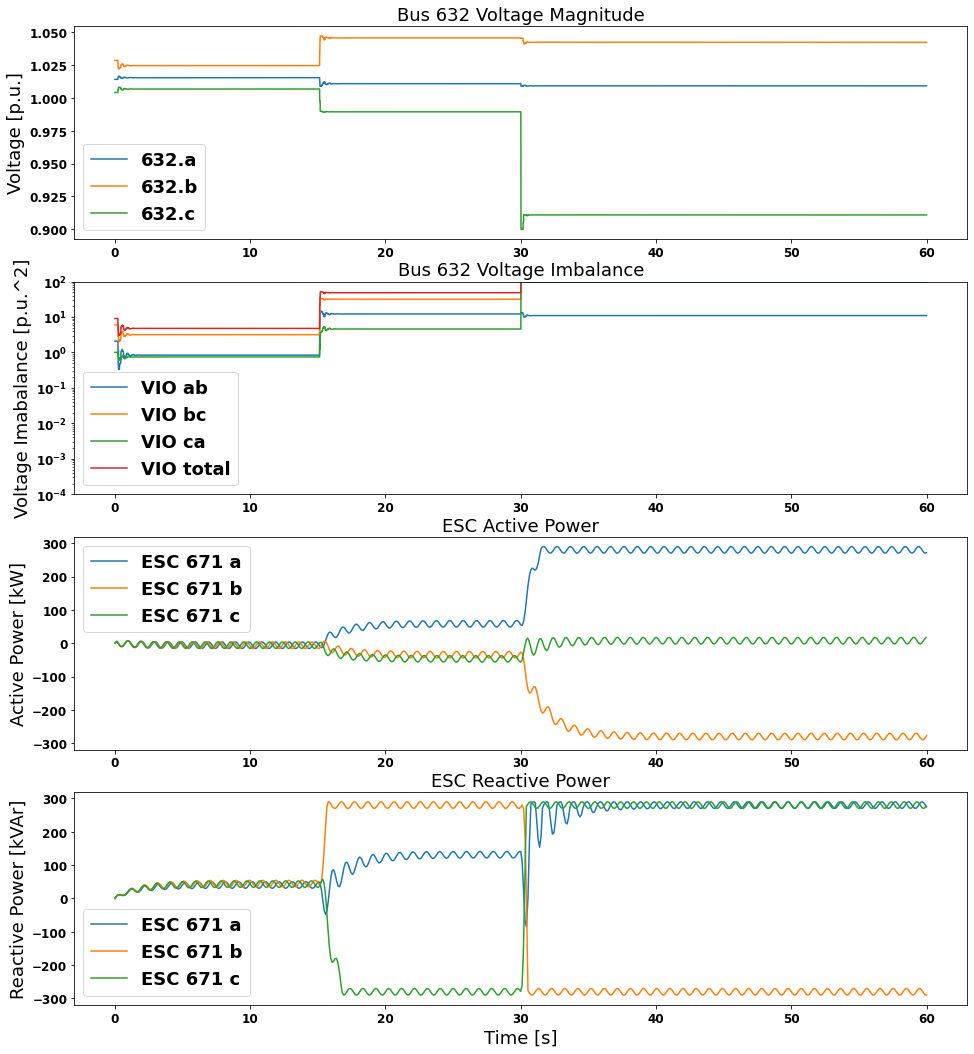

In [13]:
fig = plt.figure(figsize=[16,18])
plt.subplot(4,1,1)
plt.plot(time,AllBusVoltage[:,0,AllBuses.index('632')],label='632'+'.a')
plt.plot(time,AllBusVoltage[:,1,AllBuses.index('632')],label='632'+'.b')
plt.plot(time,AllBusVoltage[:,2,AllBuses.index('632')],label='632'+'.c')
plt.title('Bus 632 Voltage Magnitude',fontsize=18)
plt.ylabel('Voltage [p.u.]',fontsize=18)
plt.legend(fontsize=18)
plt.subplot(4,1,2)
plt.semilogy(time,Vimb[:,0],label='VIO ab')
plt.semilogy(time,Vimb[:,1],label='VIO bc')
plt.semilogy(time,Vimb[:,2],label='VIO ca')
plt.semilogy(time,Vimb[:,3],label='VIO total')
# plt.semilogy(voolist[1].timeop,voolist[1].y4,label='VIO bc')
# plt.semilogy(voolist[2].timeop,voolist[2].y4,label='VIO ca')
# plt.semilogy(voolist[2].timeop,voolist[2].y4,label='VIO ca')
# plt.semilogy(voolist[2].timeop,voolist[0].y4+voolist[1].y4+voolist[2].y4,label='Total')
plt.title('Bus 632 Voltage Imbalance',fontsize=18)
# plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Voltage Imabalance [p.u.^2]',fontsize=18)
plt.ylim([1e-4, 1e2])
plt.legend(fontsize=18)
plt.subplot(4,1,3)
plt.plot(esclist[0].timeop,esclist[0].p,label='ESC 671 a')
plt.plot(esclist[1].timeop,esclist[1].p,label='ESC 671 b')
plt.plot(esclist[2].timeop,esclist[2].p,label='ESC 671 c')
plt.title('ESC Active Power',fontsize=18)
plt.ylabel('Active Power [kW]',fontsize=18)
plt.legend(fontsize=18)
plt.subplot(4,1,4)
plt.plot(esclist[0].timeop,esclist[0].q,label='ESC 671 a')
plt.plot(esclist[1].timeop,esclist[1].q,label='ESC 671 b')
plt.plot(esclist[2].timeop,esclist[2].q,label='ESC 671 c')
plt.title('ESC Reactive Power',fontsize=18)
plt.xlabel('Time [s]',fontsize=18)
plt.ylabel('Reactive Power [kVAr]',fontsize=18)
plt.legend(fontsize=18)

plt.show()

fig.savefig('/home/michael/Desktop/temp/imbalance_reg_con_632_02.png')

In [14]:
from yaml import load, dump

try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

# ...

data = load('imbalance/test.yaml', Loader=Loader)

# ...

output = dump(data, Dumper=Dumper)

print(data)

imbalance/test.yaml


In [15]:
import yaml

a_yaml_file = open('imbalance/config_01.yaml')
parsed_yaml_file = yaml.load(a_yaml_file, Loader=yaml.FullLoader)

print(parsed_yaml_file['dssfile'])

print(parsed_yaml_file.get('dssfile'))


asdf.dss
asdf.dss


In [16]:
import yaml

with open(r'imbalance/config_01.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    fruits_list = yaml.load(file, Loader=yaml.FullLoader)

    print(fruits_list.get('inverters')[0]['bus'])

671


In [17]:
import json

with open('imbalance/config_01.json') as f:
    data = json.load(f)

# Output: {'name': 'Bob', 'languages': ['English', 'Fench']}
print(data['inverters'])

for k1 in range(len(data['inverters'])):

    print(data['inverters'][k1])

[{'bus': '671', 'phase': '1', 'conn': 'wye', 'Top': 0.1, 'Toff': 0.0, 'flp': 2, 'kVAr': 100, 'VBP': [0.92, 0.98, 1.02, 1.08]}, {'bus': '671', 'phase': '2', 'conn': 'wye', 'Top': 0.1, 'Toff': 0.0, 'flp': 2, 'kVAr': 100, 'VBP': [0.92, 0.98, 1.02, 1.08]}, {'bus': '671', 'phase': '3', 'conn': 'wye', 'Top': 0.1, 'Toff': 0.0, 'flp': 2, 'kVAr': 100, 'VBP': [0.92, 0.98, 1.02, 1.08]}, {'bus': '675', 'phase': '1', 'conn': 'wye', 'Top': 0.1, 'Toff': 0.0, 'flp': 2, 'kVAr': 100, 'VBP': [0.92, 0.98, 1.02, 1.08]}, {'bus': '675', 'phase': '2', 'conn': 'wye', 'Top': 0.1, 'Toff': 0.0, 'flp': 2, 'kVAr': 100, 'VBP': [0.92, 0.98, 1.02, 1.08]}, {'bus': '675', 'phase': '3', 'conn': 'wye', 'Top': 0.1, 'Toff': 0.0, 'flp': 2, 'kVAr': 100, 'VBP': [0.92, 0.98, 1.02, 1.08]}]
{'bus': '671', 'phase': '1', 'conn': 'wye', 'Top': 0.1, 'Toff': 0.0, 'flp': 2, 'kVAr': 100, 'VBP': [0.92, 0.98, 1.02, 1.08]}
{'bus': '671', 'phase': '2', 'conn': 'wye', 'Top': 0.1, 'Toff': 0.0, 'flp': 2, 'kVAr': 100, 'VBP': [0.92, 0.98, 1.02, 

In [18]:
AllBuses.index(inverlist)

NameError: name 'inverlist' is not defined

In [7]:
esclist[0].busname

'671'

In [19]:
inverterlist[0].measure_voltage(inverter.kop,AllBusVoltage[kt,inverterlist[0].phase-1,AllBuses.index(inverterlist[0].busname)])

In [20]:
inverterlist[1].phase

array([2])